<a href="https://colab.research.google.com/github/veranoviani/Vera-Noviani__explanatory_model_analysis__fraud_detection/blob/main/Assignment_Day_9_10_Vera_Noviani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library#

In [ ]:
!pip install -U xgboost 
!pip install skope-rules
!pip install eli5
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.tree import plot_tree, export_text
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc,roc_auc_score
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay

import statsmodels.api as sm
import statsmodels.formula.api as smf

from skrules import SkopeRules
from xgboost import XGBClassifier

import scikitplot as skplt

import eli5

In [ ]:
def create_stacked_bar_percent(df,column_name):
        
    # Get the percentage of default by each group
    default_by_group = pd.crosstab(index=df['fraud_reported'],columns = df[column_name], normalize = 'columns')
    default_by_group = default_by_group[default_by_group.iloc[1].sort_values().index]
    
    # Round up to 2 decimal
    default_by_group = default_by_group.apply(lambda x: round(x,2))
    
    labels = default_by_group.columns
    list1 = default_by_group.iloc[0].to_list()
    list2 = default_by_group.iloc[1].to_list()
    
    list1_name = "Not Fraud"
    list2_name = "Fraud"
    title = f" %Fraud by {column_name}"
    xlabel = column_name
    ylabel = "Number of Fraud"
    
    fig, ax = plt.subplots(figsize=(8,8),dpi=100)
    bar_width = 0.5
    
    ax1 = ax.bar(labels,list1, bar_width, label = list1_name)
    ax2 = ax.bar(labels,list2, bar_width, bottom = list1, label = list2_name)

    ax.set_title(title, fontweight = "bold",fontsize=12)
    ax.set_xlabel(xlabel, fontweight = "bold",fontsize=12)
    ax.set_ylabel(ylabel, fontweight = "bold",fontsize=12)
    ax.legend(loc="upper right")
    
    plt.xticks(list(range(len(labels))), labels,rotation=90)
    plt.yticks(fontsize=12)

    for r1, r2 in zip(ax1, ax2):
        h1 = r1.get_height()
        h2 = r2.get_height()
        plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., f"{h1:.0%}", ha="center", va="center", color="black", fontsize=12, fontweight="bold")
        plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., f"{h2:.0%}", ha="center", va="center", color="black", fontsize=12, fontweight="bold")

    plt.show()

#Load Data Set#

In [ ]:
# insurance fraud
df = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/car_insurance_fraud_dataset/insuranceFraud.csv")

In [ ]:
df.head()

months_as_customer  age  policy_number policy_bind_date policy_state  \
0                 328   48         521585       10/17/2014           OH   
1                 228   42         342868        6/27/2006           IN   
2                 134   29         687698         9/6/2000           OH   
3                 256   41         227811        5/25/1990           IL   
4                 228   44         367455         6/6/2014           IL   

  policy_csl  policy_deductable  policy_annual_premium  umbrella_limit  \
0    250/500               1000                1406.91               0   
1    250/500               2000                1197.22         5000000   
2    100/300               2000                1413.14         5000000   
3    250/500               2000                1415.74         6000000   
4   500/1000               1000                1583.91         6000000   

   insured_zip  ... witnesses police_report_available total_claim_amount  \
0       466132  ...         2                     YES              71610   
1       468176  ...         0                       ?               5070   
2       430632  ...         3                      NO              34650   
3       608117  ...         2                      NO              63400   
4       610706  ...         1                      NO               6500   

  injury_claim property_claim  vehicle_claim  auto_make auto_model auto_year  \
0         6510          13020          52080       Saab        92x      2004   
1          780            780           3510   Mercedes       E400      2007   
2         7700           3850          23100      Dodge        RAM      2007   
3         6340           6340          50720  Chevrolet      Tahoe      2014   
4         1300            650           4550     Accura        RSX      2009   

  fraud_reported  
0              Y  
1              Y  
2              N  
3              Y  
4              N  

[5 rows x 39 columns]

#Data Understanding#

In [ ]:
for x in df.columns:
    print(f"Unik value dari {x}")
    print(f"{df[x].unique()}")
    print()

Unik value dari months_as_customer
[328 228 134 256 137 165  27 212 235 447  60 121 180 473  70 140 160 196
 460 217 370 413 237   8 257 202 224 241  64 166 155 114 149 147  62 289
 431 199  79 116  37 106 269 265 163 355 175 192 430  91 223 195  22 439
  94  11 151 154 245 119 215 295 254 107 478 128 338 271 222 120 270 319
 194 227 244  78 200 284 275 153  31  41 127  61 207 219  80 325  29 239
 279 350 464 118 298  87 261 453 210 168 390 258 225 164 255 206 203 211
 274  81 280 112  24  93 171 124 287 122 398 214 209  82 193 288 104 101
 375 461 428  45 136 216 278 108  14 276  47  73 294 324  53 426 111  86
 296 125 177 238 449 252 359  19 285  30 342 468 343 404  63 335 142 272
  69  38 281 246 330 362 371 377 172  99 249 190 174  95   2 117 242 440
  20 208 156 232  84 394  35 369 332 243 264  32 259 186 201 436 189 105
  88  40  59  39 123 231 247  48 267 286 253  10 158   1  85 233 266  97
 399 305 129 283  96 176 159 290 299  66 334 429  15 230 250  65 475  77
 229 110 292 451

#No 1. Identifikasi Nilai Null yang terdapat didalam dataset#


In [ ]:
#replace ? with NaN
col_replace = ['collision_type','property_damage','police_report_available']

#perform replace function
df[col_replace] = df[col_replace].replace("?",np.nan)

#check missing values
df.isnull().sum()

months_as_customer               0
age                              0
policy_number                    0
policy_bind_date                 0
policy_state                     0
policy_csl                       0
policy_deductable                0
policy_annual_premium            0
umbrella_limit                   0
insured_zip                      0
insured_sex                      0
insured_education_level          0
insured_occupation               0
insured_hobbies                  0
insured_relationship             0
capital-gains                    0
capital-loss                     0
incident_date                    0
incident_type                    0
collision_type                 178
incident_severity                0
authorities_contacted            0
incident_state                   0
incident_city                    0
incident_location                0
incident_hour_of_the_day         0
number_of_vehicles_involved      0
property_damage                360
bodily_injuries     

Hasil dari dataset yang di indikasi dengan tanda "?", sehingga perlu di proses dengan mengubahnya menjadi nilai Null atau NaN. Dari hasil proses terlihat bahwa kolom collision_type, property_damage, police_report_available  dengan total nilai missing pada data set adalah sebesar 881



#No 2 Treatment Missing Values#

In [ ]:
#check values counts
for i in col_replace:
  print(f"{df[i].value_counts()/len(df)}")
  print()

Rear Collision     0.292
Side Collision     0.276
Front Collision    0.254
Name: collision_type, dtype: float64

NO     0.338
YES    0.302
Name: property_damage, dtype: float64

NO     0.343
YES    0.314
Name: police_report_available, dtype: float64



Dari hasil perhitungan, terlihat setiap nilai memiliki nilai yang relative dekat sementara kita belum mengetahui hal yang pasti terkait missing values ini, maka akan dilakukan imputasi dengan nilai Unknown, tetapi jika hasil analisis menunjukkan bahwa Unknown tidak memberikan informasi, maka akan dilakukan imputasi yang lain.

In [ ]:
#imputation to unknown
df[col_replace] = df[col_replace].fillna('Unknown')

#recheck again
df.isnull().sum()


months_as_customer             0
age                            0
policy_number                  0
policy_bind_date               0
policy_state                   0
policy_csl                     0
policy_deductable              0
policy_annual_premium          0
umbrella_limit                 0
insured_zip                    0
insured_sex                    0
insured_education_level        0
insured_occupation             0
insured_hobbies                0
insured_relationship           0
capital-gains                  0
capital-loss                   0
incident_date                  0
incident_type                  0
collision_type                 0
incident_severity              0
authorities_contacted          0
incident_state                 0
incident_city                  0
incident_location              0
incident_hour_of_the_day       0
number_of_vehicles_involved    0
property_damage                0
bodily_injuries                0
witnesses                      0
police_rep

Dari hasil proses treatment yang dilakukan mengimputasi ke unknown dapat menangani missing value yang terjadi.

#No 3. Analisis Target Variable#


In [ ]:
df.columns

Index(['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_state', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital-gains', 'capital-loss',
       'incident_date', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported'],
      dtype='object')

Dalam kasus fraud asuransi, hal yang membuat orang melakukan kecurangan ialah demi mendapatkan claim asuransi yang dimana dengan menginfokan beberapa kecelakaan yang dialaminya. 

Kolom-kolom yang relevant ialah incident_type, policy_deductable, total_claim_amount, injury_claim , property_claim, vechile_claim, policy_annual_premium , umbrella_limit , capital_gains , capital_loss , incident_severity, insured_occupation

target : fraud_reported

In [ ]:
#policy number as index
df = df.set_index('policy_number')
df.head()

months_as_customer  age policy_bind_date policy_state  \
policy_number                                                          
521585                        328   48       10/17/2014           OH   
342868                        228   42        6/27/2006           IN   
687698                        134   29         9/6/2000           OH   
227811                        256   41        5/25/1990           IL   
367455                        228   44         6/6/2014           IL   

              policy_csl  policy_deductable  policy_annual_premium  \
policy_number                                                        
521585           250/500               1000                1406.91   
342868           250/500               2000                1197.22   
687698           100/300               2000                1413.14   
227811           250/500               2000                1415.74   
367455          500/1000               1000                1583.91   

               umbrella_limit  insured_zip insured_sex  ... witnesses  \
policy_number                                           ...             
521585                      0       466132        MALE  ...         2   
342868                5000000       468176        MALE  ...         0   
687698                5000000       430632      FEMALE  ...         3   
227811                6000000       608117      FEMALE  ...         2   
367455                6000000       610706        MALE  ...         1   

              police_report_available total_claim_amount injury_claim  \
policy_number                                                           
521585                            YES              71610         6510   
342868                        Unknown               5070          780   
687698                             NO              34650         7700   
227811                             NO              63400         6340   
367455                             NO               6500         1300   

               property_claim  vehicle_claim  auto_make auto_model auto_year  \
policy_number                                                                  
521585                  13020          52080       Saab        92x      2004   
342868                    780           3510   Mercedes       E400      2007   
687698                   3850          23100      Dodge        RAM      2007   
227811                   6340          50720  Chevrolet      Tahoe      2014   
367455                    650           4550     Accura        RSX      2009   

              fraud_reported  
policy_number                 
521585                     Y  
342868                     Y  
687698                     N  
227811                     Y  
367455                     N  

[5 rows x 38 columns]

In [ ]:
#convert y and n in fraud reported
df['fraud_reported'] = df["fraud_reported"].replace(["Y","N"],[1,0])
df.head()

months_as_customer  age policy_bind_date policy_state  \
policy_number                                                          
521585                        328   48       10/17/2014           OH   
342868                        228   42        6/27/2006           IN   
687698                        134   29         9/6/2000           OH   
227811                        256   41        5/25/1990           IL   
367455                        228   44         6/6/2014           IL   

              policy_csl  policy_deductable  policy_annual_premium  \
policy_number                                                        
521585           250/500               1000                1406.91   
342868           250/500               2000                1197.22   
687698           100/300               2000                1413.14   
227811           250/500               2000                1415.74   
367455          500/1000               1000                1583.91   

               umbrella_limit  insured_zip insured_sex  ... witnesses  \
policy_number                                           ...             
521585                      0       466132        MALE  ...         2   
342868                5000000       468176        MALE  ...         0   
687698                5000000       430632      FEMALE  ...         3   
227811                6000000       608117      FEMALE  ...         2   
367455                6000000       610706        MALE  ...         1   

              police_report_available total_claim_amount injury_claim  \
policy_number                                                           
521585                            YES              71610         6510   
342868                        Unknown               5070          780   
687698                             NO              34650         7700   
227811                             NO              63400         6340   
367455                             NO               6500         1300   

               property_claim  vehicle_claim  auto_make auto_model auto_year  \
policy_number                                                                  
521585                  13020          52080       Saab        92x      2004   
342868                    780           3510   Mercedes       E400      2007   
687698                   3850          23100      Dodge        RAM      2007   
227811                   6340          50720  Chevrolet      Tahoe      2014   
367455                    650           4550     Accura        RSX      2009   

              fraud_reported  
policy_number                 
521585                     1  
342868                     1  
687698                     0  
227811                     1  
367455                     0  

[5 rows x 38 columns]

In [ ]:
# create predictor variables as X
X = df.drop(['fraud_reported'], axis = 1)
# create target data as y
y = df['fraud_reported']

In [ ]:
# split data to train and test data
# where 30% of fraud_reported data are test data
# stratify data based on y varibales
# and freeze RNG with random_state = 1000
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    test_size=0.3,
    stratify = y, 
    random_state=1000
)

In [ ]:
# check train data dimension
X_train.shape

(700, 37)

In [ ]:
# check test data dimension
X_test.shape

(300, 37)

In [ ]:
# check train target counts
y_train.value_counts()

0    527
1    173
Name: fraud_reported, dtype: int64

In [ ]:
# check test target counts
y_test.value_counts()

0    226
1     74
Name: fraud_reported, dtype: int64

In [ ]:
# create correlation matrix
df.corr()

months_as_customer       age  policy_deductable  \
months_as_customer                     1.000000  0.922098           0.026807   
age                                    0.922098  1.000000           0.029188   
policy_deductable                      0.026807  0.029188           1.000000   
policy_annual_premium                  0.005018  0.014404          -0.003245   
umbrella_limit                         0.015498  0.018126           0.010870   
insured_zip                            0.017895  0.025604           0.004545   
capital-gains                          0.006399 -0.007075           0.035212   
capital-loss                           0.020209  0.007368          -0.023544   
incident_hour_of_the_day               0.070639  0.087161           0.060935   
number_of_vehicles_involved            0.014736  0.022102           0.051214   
bodily_injuries                       -0.010162 -0.015679          -0.022765   
witnesses                              0.058383  0.052359           0.066639   
total_claim_amount                     0.062108  0.069863           0.022839   
injury_claim                           0.065329  0.075522           0.039107   
property_claim                         0.034940  0.060898           0.064792   
vehicle_claim                          0.061013  0.062588           0.005269   
auto_year                             -0.000292  0.001354           0.026105   
fraud_reported                         0.020544  0.012143           0.014817   

                             policy_annual_premium  umbrella_limit  \
months_as_customer                        0.005018        0.015498   
age                                       0.014404        0.018126   
policy_deductable                        -0.003245        0.010870   
policy_annual_premium                     1.000000       -0.006247   
umbrella_limit                           -0.006247        1.000000   
insured_zip                               0.032354        0.019671   
capital-gains                            -0.013738       -0.047268   
capital-loss                              0.023547       -0.024056   
incident_hour_of_the_day                 -0.001578       -0.023257   
number_of_vehicles_involved              -0.045991       -0.021270   
bodily_injuries                           0.026780        0.022743   
witnesses                                 0.002332       -0.006738   
total_claim_amount                        0.009094       -0.040344   
injury_claim                             -0.017633       -0.045412   
property_claim                           -0.011654       -0.023790   
vehicle_claim                             0.020246       -0.038584   
auto_year                                -0.049226        0.009893   
fraud_reported                           -0.014480        0.058622   

                             insured_zip  capital-gains  capital-loss  \
months_as_customer              0.017895       0.006399      0.020209   
age                             0.025604      -0.007075      0.007368   
policy_deductable               0.004545       0.035212     -0.023544   
policy_annual_premium           0.032354      -0.013738      0.023547   
umbrella_limit                  0.019671      -0.047268     -0.024056   
insured_zip                     1.000000       0.006303      0.049372   
capital-gains                   0.006303       1.000000     -0.046904   
capital-loss                    0.049372      -0.046904      1.000000   
incident_hour_of_the_day        0.008274      -0.016406     -0.025054   
number_of_vehicles_involved     0.027448       0.061643     -0.014895   
bodily_injuries                 0.028695       0.055829     -0.024418   
witnesses                       0.019805      -0.017651     -0.041330   
total_claim_amount             -0.033873       0.015980     -0.036060   
injury_claim                   -0.017495       0.025934     -0.046060   
property_claim                 -0.006841      -0.000779     -0.022863   
vehicle_c

Kita dapat melihat beberapa kolom memiliki korelasi yang kuat misalnya total claim amount, property claim , injury claim dan vechile claim. Kita bisa menganalisanya lebih jauh. Manakah dari variabel tersebut yang memiliki korelasi lebih kuat dengan insurance fraud.

In [ ]:
# pull numerical column
var_name = X_train.select_dtypes(include = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])

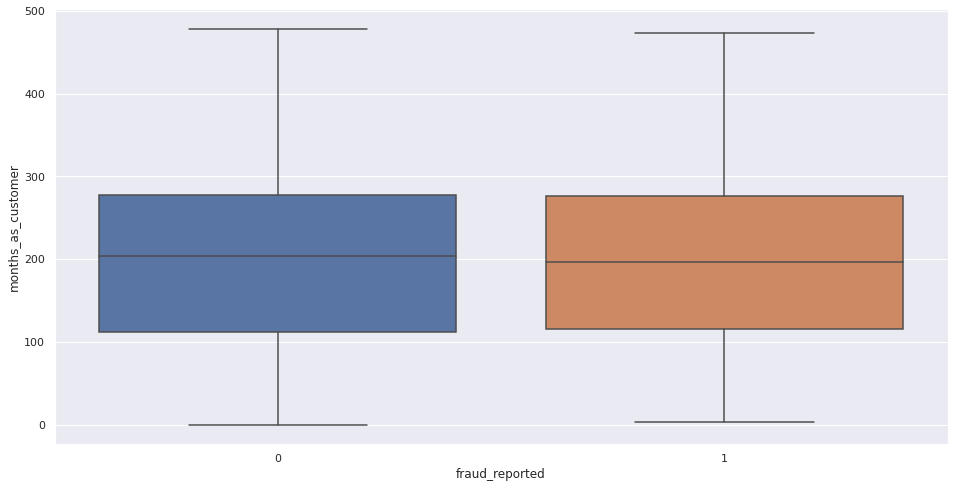

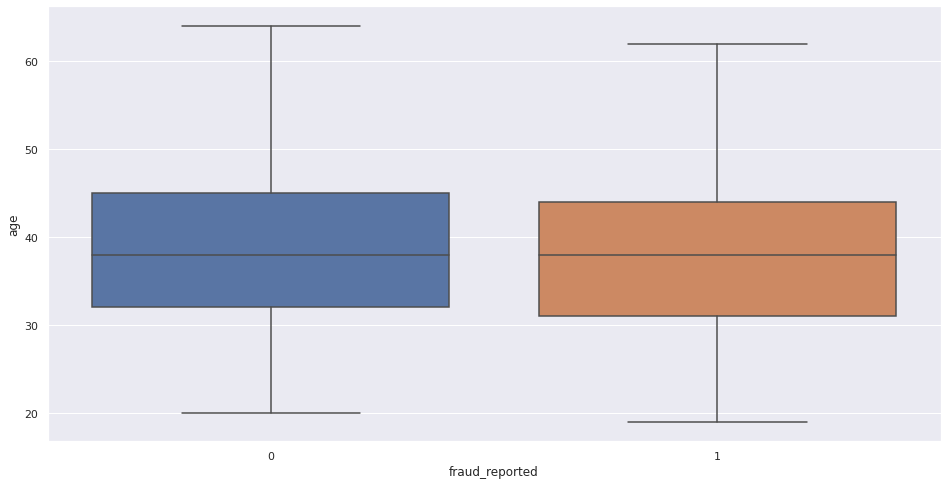

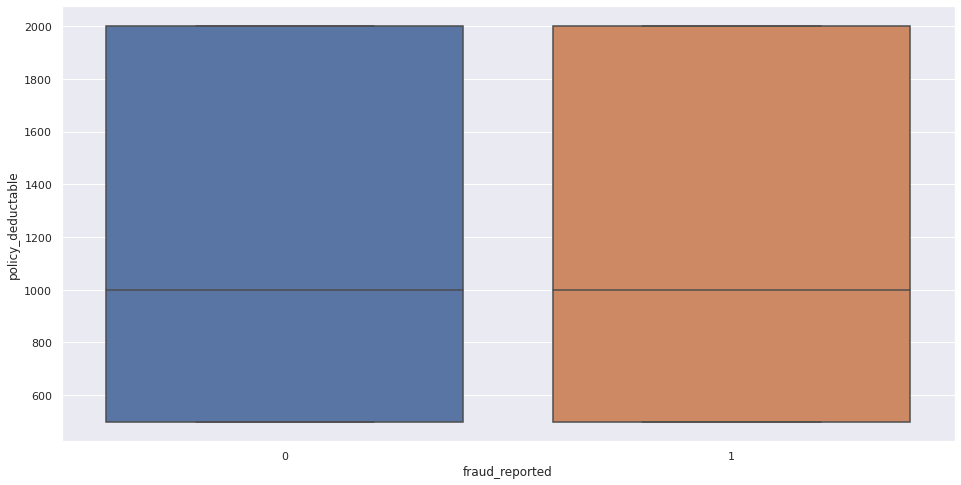

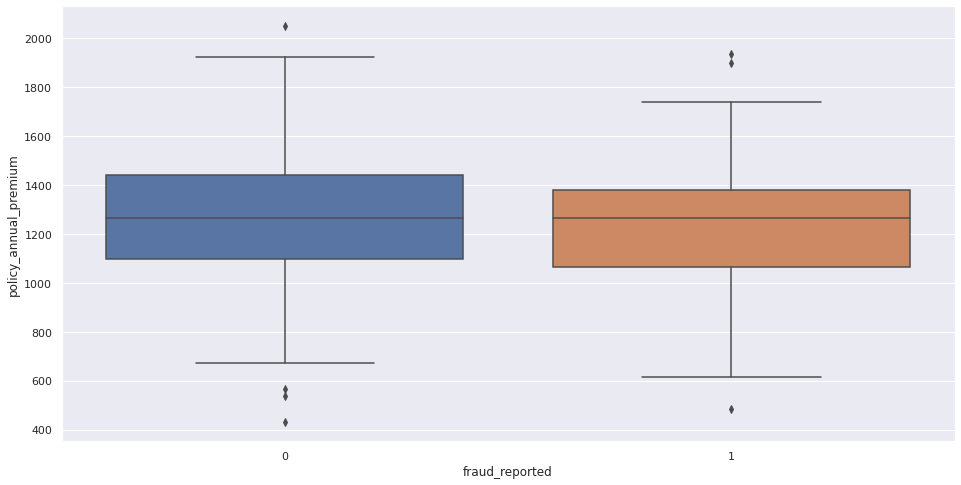

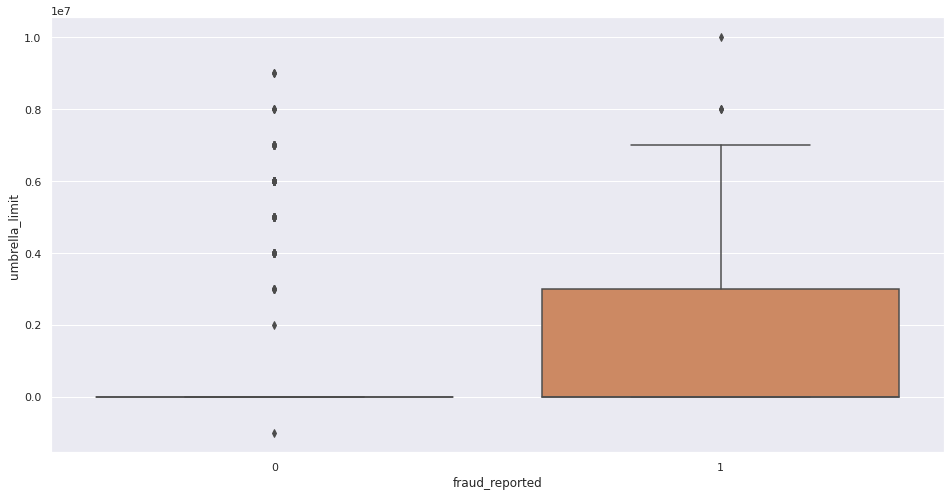

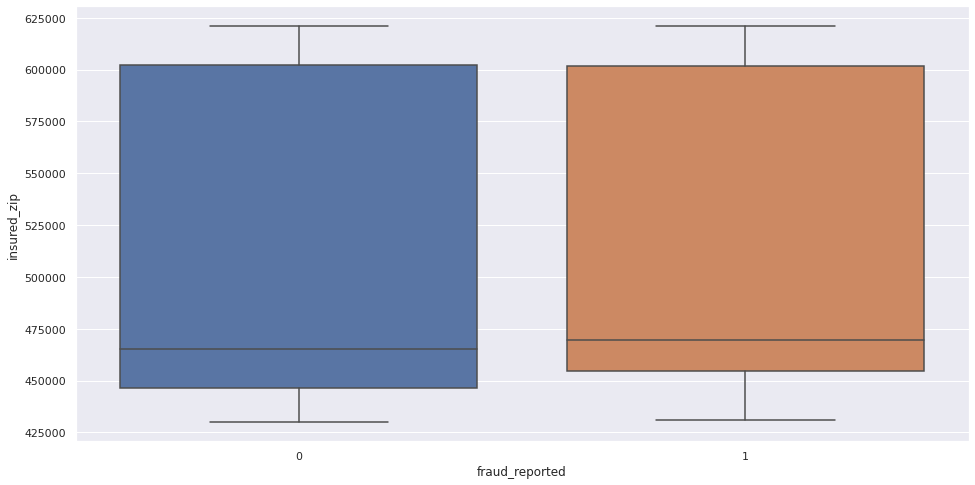

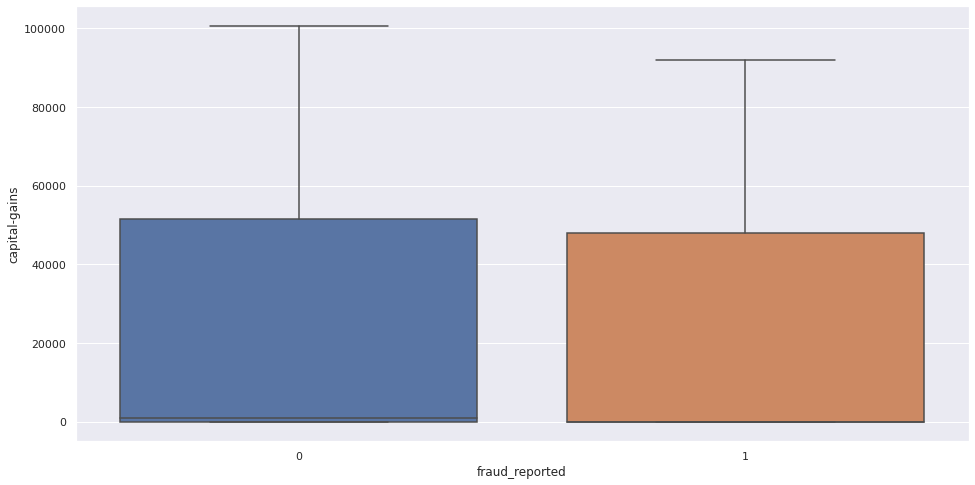

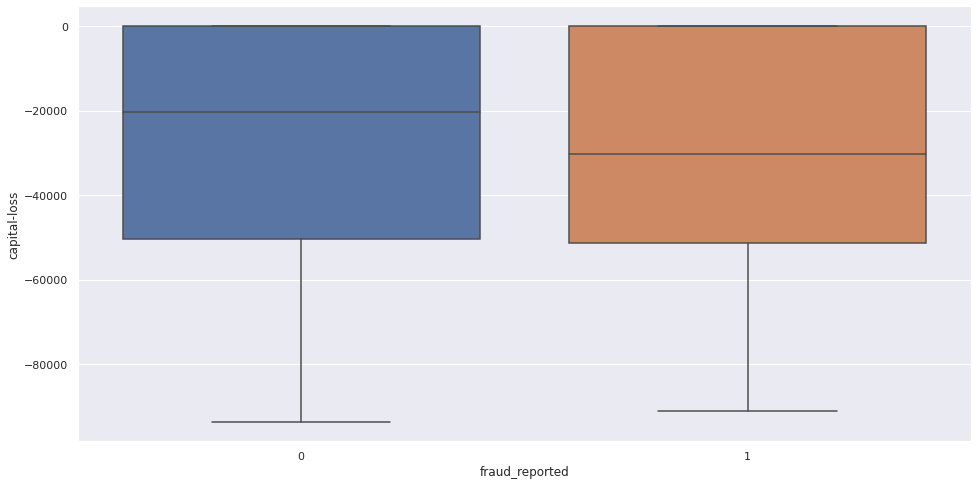

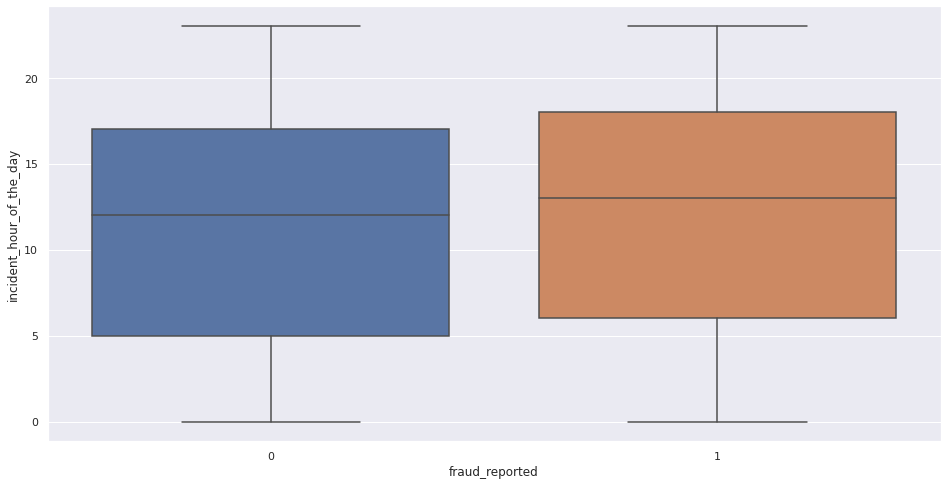

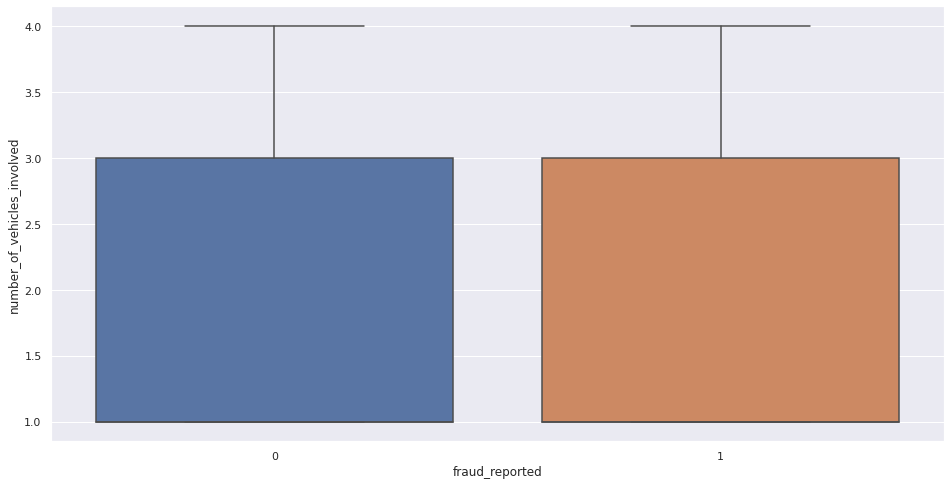

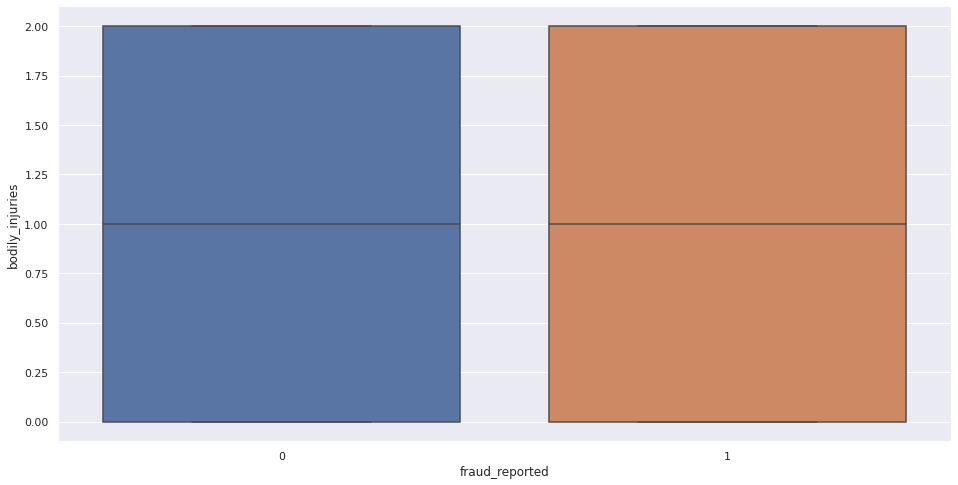

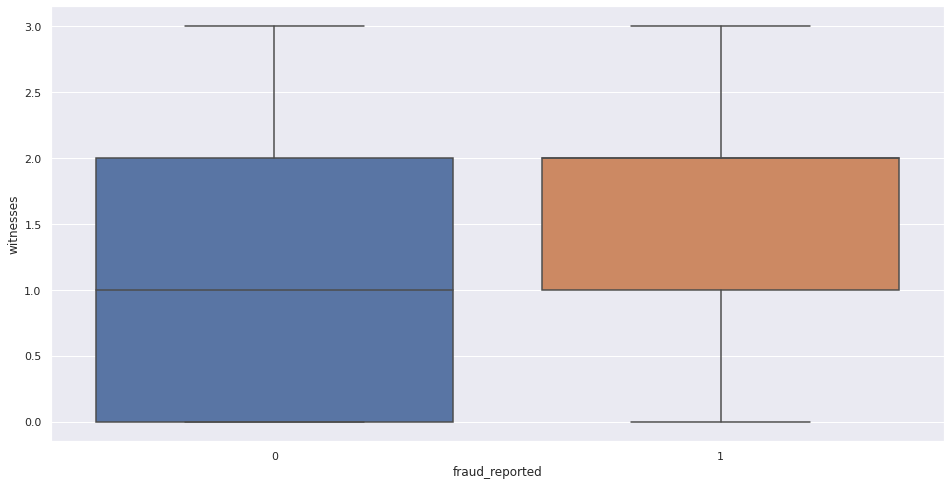

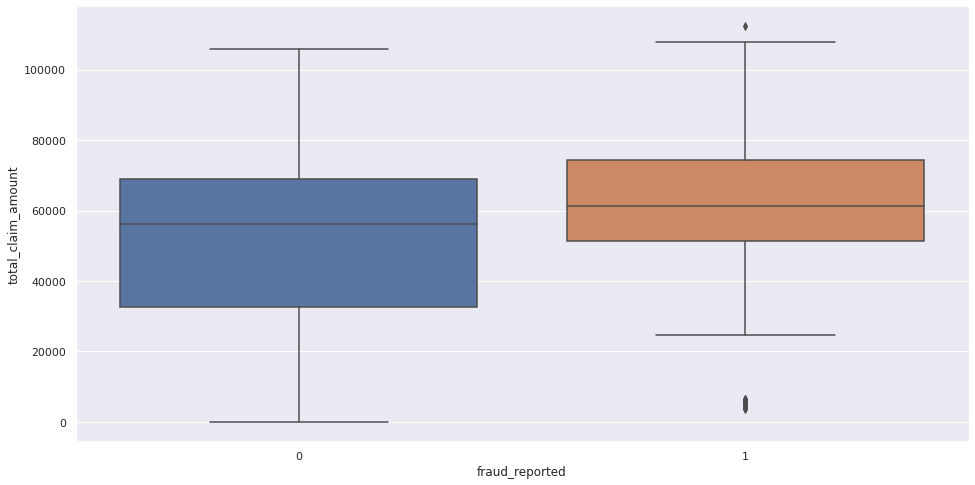

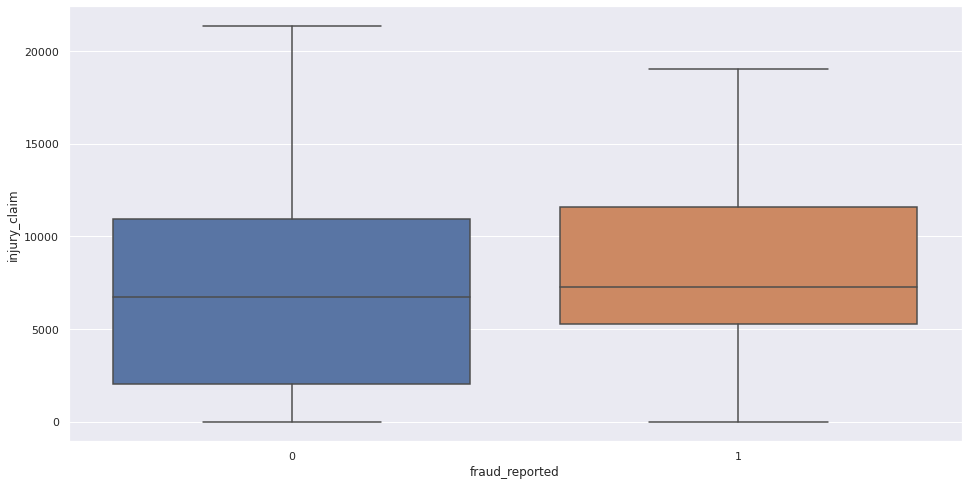

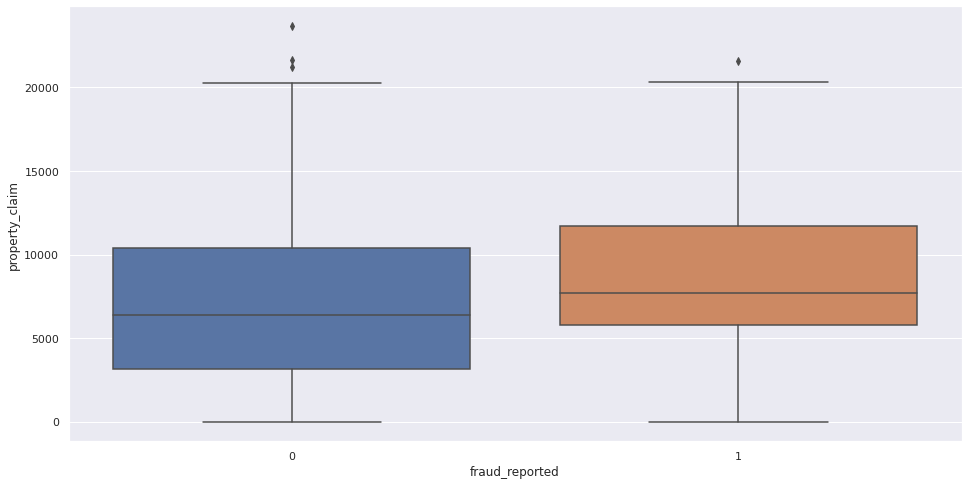

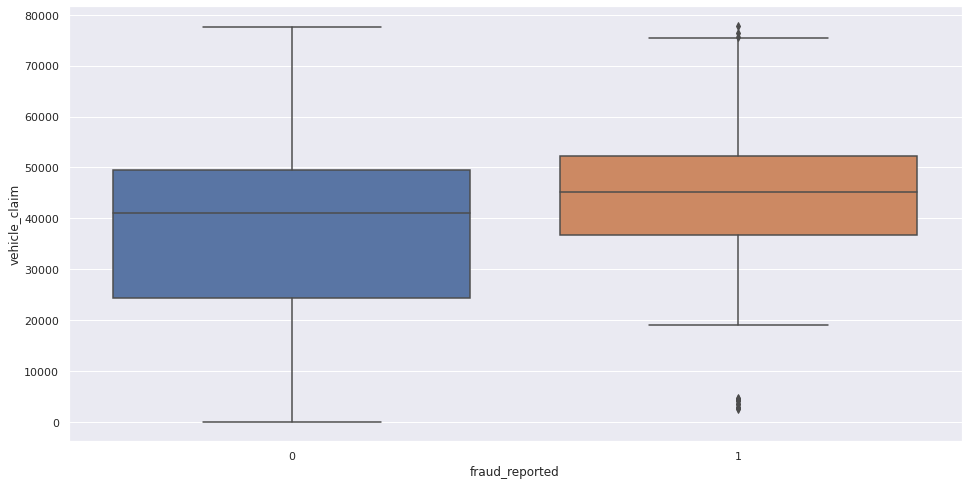

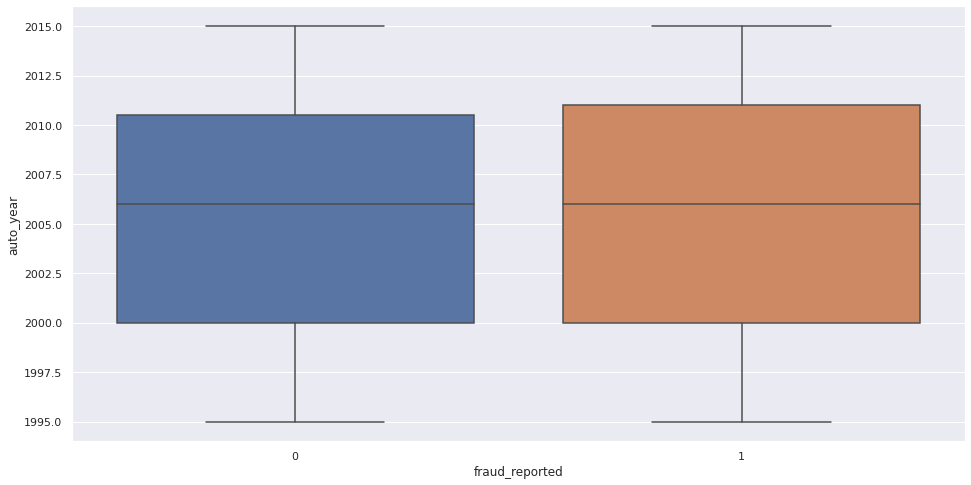

In [ ]:
# plot box plot
for col_names in var_name:
  plt.figure()
  sns.boxplot(x = y_train, y = X_train[col_names]);

Dilihat dari data di atas terdapat faktor-faktor yang kuat terhadap kasus fraud dimana Capital Loss, Total Claim , Injury Claim ,Property Claim serta Vehicle Claim 

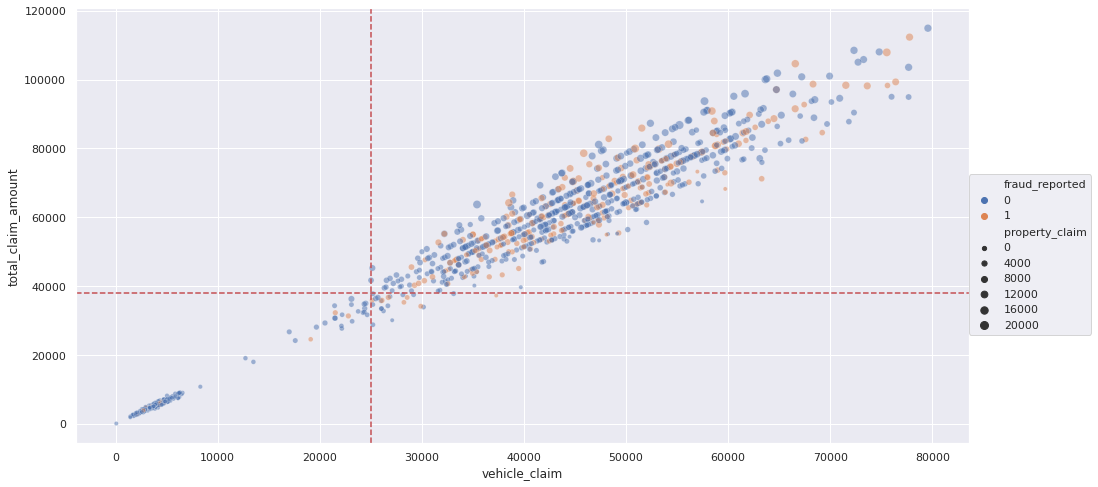

In [ ]:
sns.scatterplot(data=df,x="vehicle_claim",y="total_claim_amount",size="property_claim",hue="fraud_reported",alpha=0.5)
plt.axvline(x=25000,color="r",linestyle="--")
plt.axhline(y=38000,color="r",linestyle="--")
plt.legend(loc=(1,0.25))

#sns.scatterplot(data=df,x="vehicle_claim",y="total_claim_amount",hue="fraud_reported",alpha=0.5)

seperti yang terlihat bahwa banyak fraud terjadi ketika total claim diatas 39000 dan vehicle diatas 25000 ribu

In [ ]:
#find the categorical column
cat = df.select_dtypes(include=["object"]).columns
cat

Index(['policy_bind_date', 'policy_state', 'policy_csl', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'incident_date', 'incident_type',
       'collision_type', 'incident_severity', 'authorities_contacted',
       'incident_state', 'incident_city', 'incident_location',
       'property_damage', 'police_report_available', 'auto_make',
       'auto_model'],
      dtype='object')

Dan jika di lihat dalam kasus fraud yang sesuai untuk dijadikan model dalam melihat kasus tersebut ialah policy_deductable , umbrella_limit, incident_type , collision_type, incident_severity, authorities_contacted, insured_hobbies , incident_state , witnesses , bodily_injuries




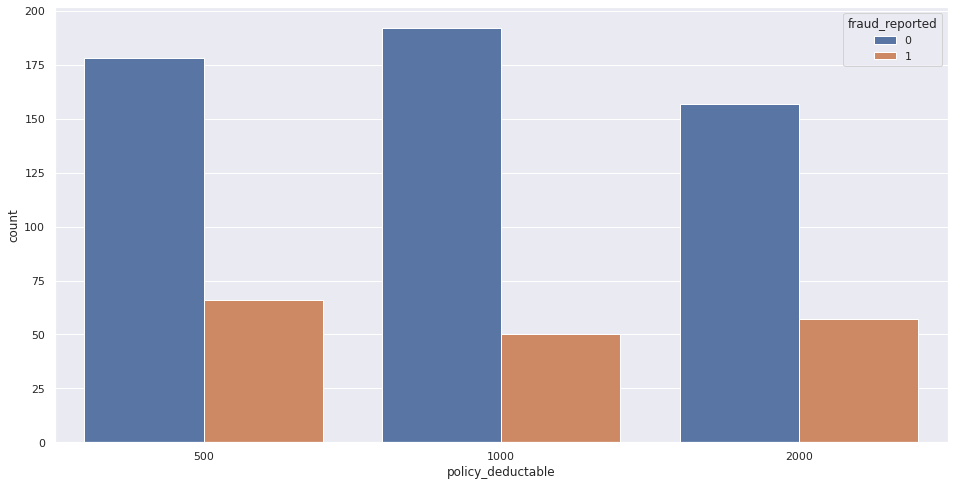

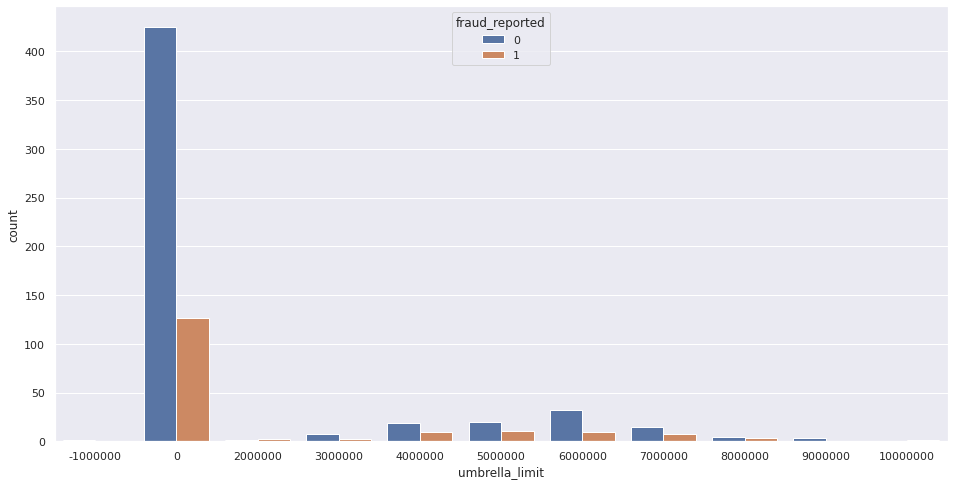

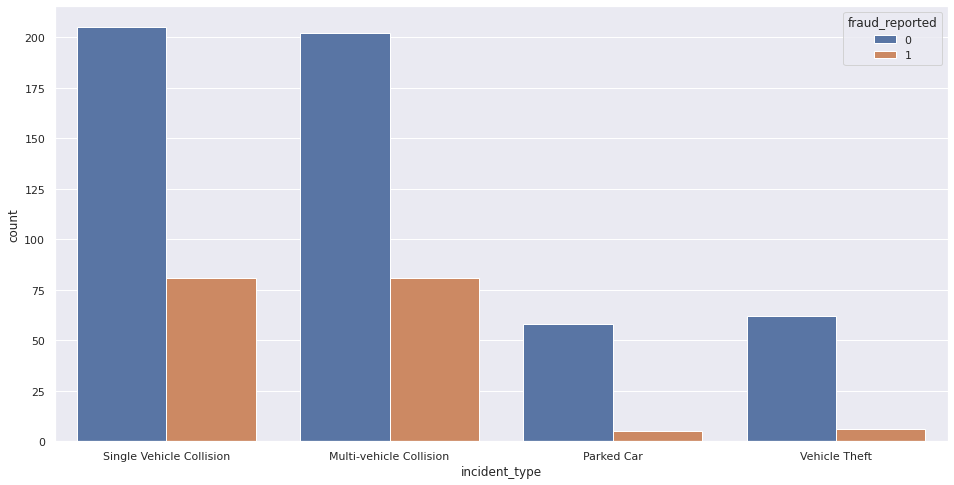

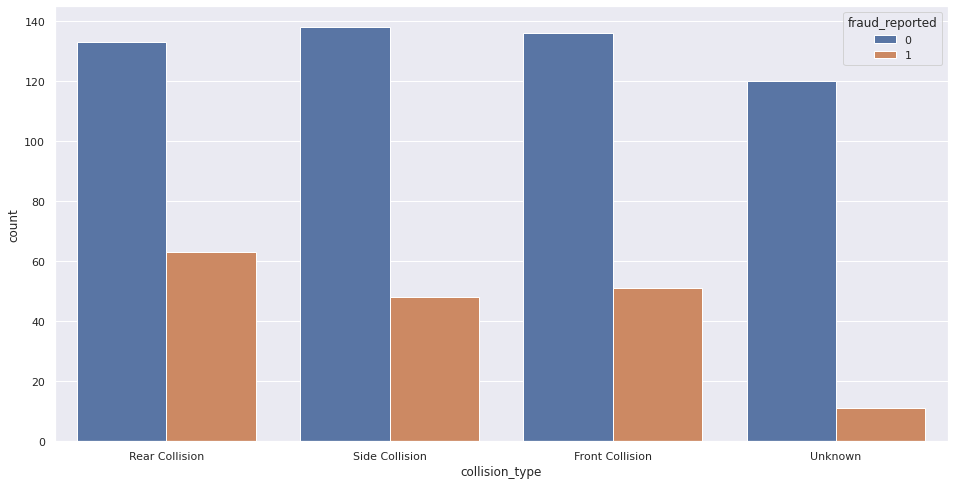

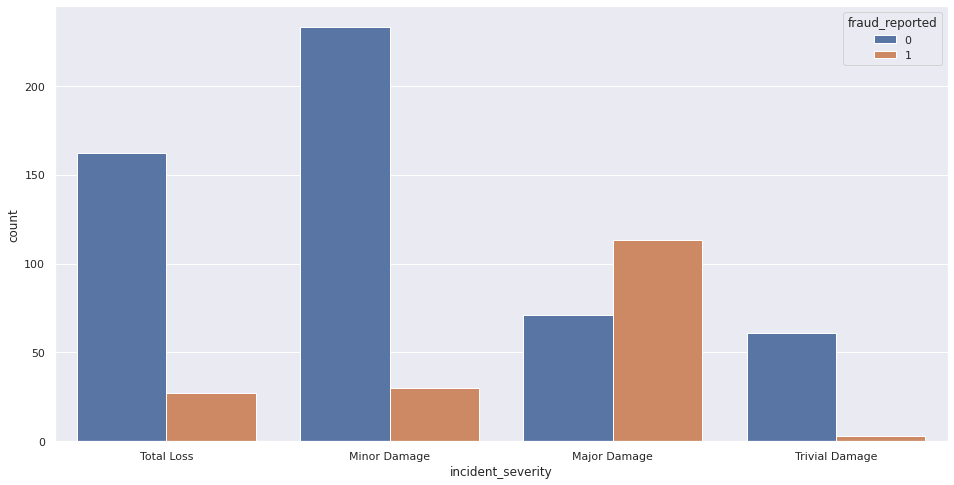

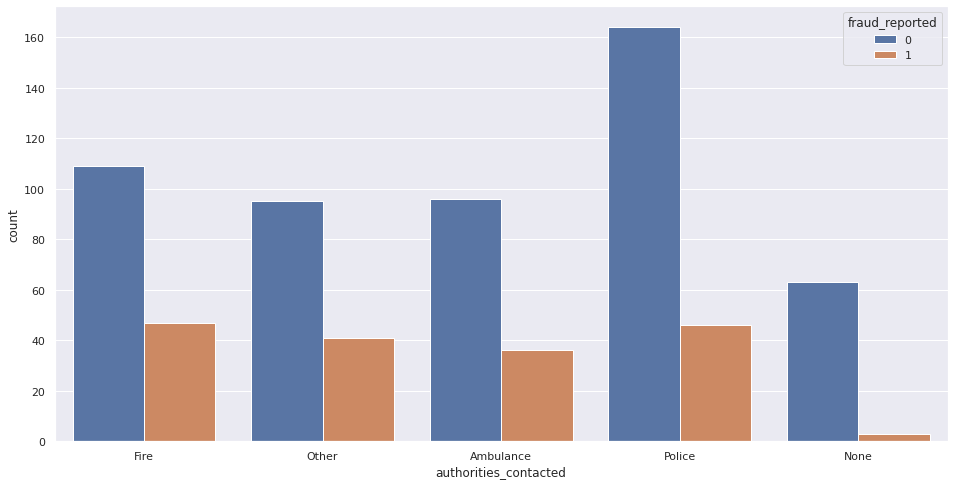

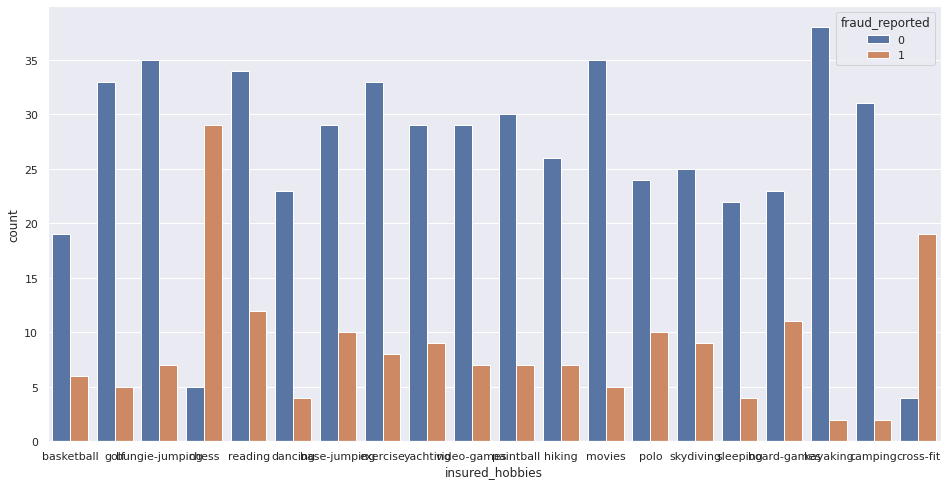

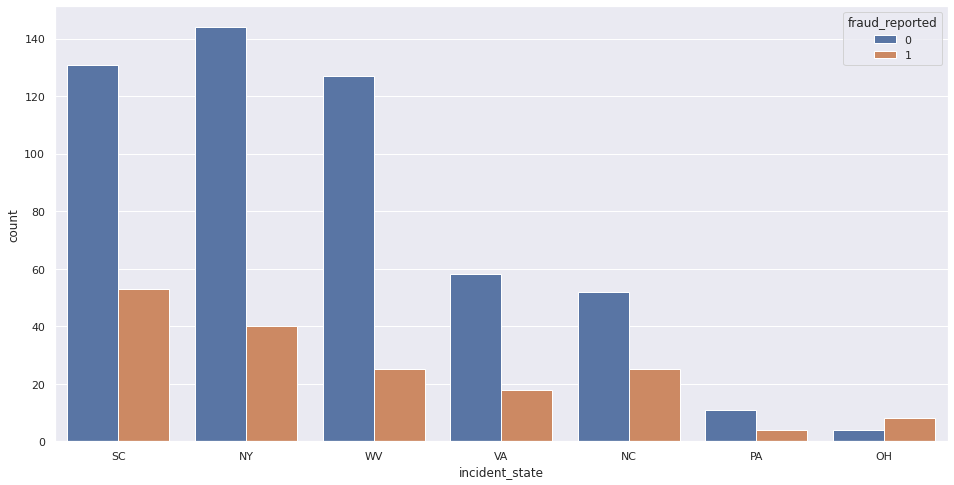

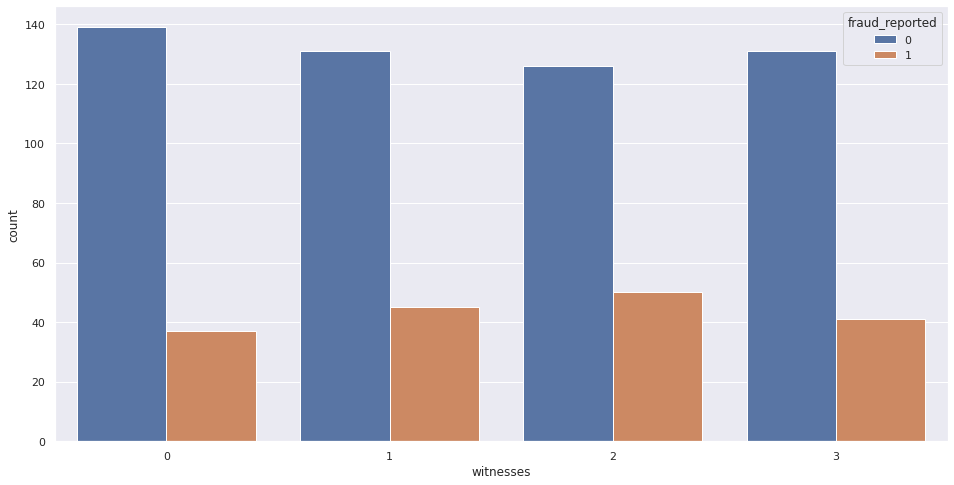

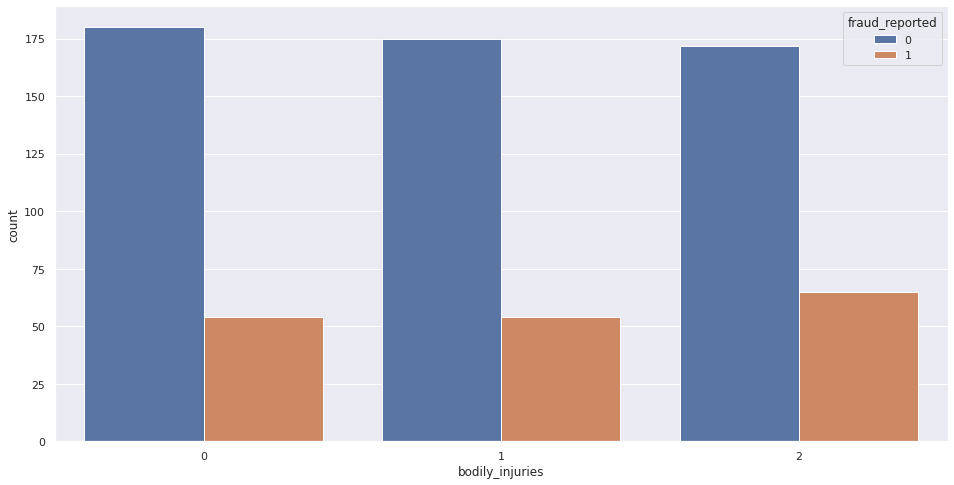

In [ ]:
categ = ['policy_deductable' , 'umbrella_limit', 'incident_type' , 'collision_type', 
         'incident_severity', 'authorities_contacted',
         'insured_hobbies' , 'incident_state' , 'witnesses' , 'bodily_injuries' ]

for col_names in categ:
  plt.figure()
  sns.countplot(x = X_train[col_names], hue = y_train);

In [ ]:
data_trend = pd.concat([X_train, y_train], axis = 1)
data_trend.head()

months_as_customer  age policy_bind_date policy_state  \
policy_number                                                          
796005                        173   36        8/18/2007           OH   
184938                          2   28        5/22/1999           IL   
615047                        286   47       11/20/2002           IN   
593466                        435   60       11/21/2006           OH   
454086                        216   36       11/10/1992           IN   

              policy_csl  policy_deductable  policy_annual_premium  \
policy_number                                                        
796005           250/500               1000                1274.63   
184938           250/500               1000                1340.56   
615047           250/500                500                1386.93   
593466          500/1000                500                1064.49   
454086          500/1000               1000                1152.40   

               umbrella_limit  insured_zip insured_sex  ... witnesses  \
policy_number                                           ...             
796005                      0       441298        MALE  ...         3   
184938                      0       433184      FEMALE  ...         2   
615047                      0       457130        MALE  ...         0   
593466                5000000       462804        MALE  ...         1   
454086                      0       615921      FEMALE  ...         3   

              police_report_available total_claim_amount injury_claim  \
policy_number                                                           
796005                             NO              52030         9460   
184938                            YES              58140         6460   
615047                             NO              65800        13160   
593466                        Unknown              62880         5240   
454086                        Unknown               6160          560   

               property_claim  vehicle_claim auto_make auto_model auto_year  \
policy_number                                                                 
796005                   9460          33110    Accura        MDX      1995   
184938                   6460          45220      Saab        92x      2008   
615047                   6580          46060    Accura         TL      2001   
593466                  10480          47160  Mercedes       E400      2007   
454086                   1680           3920  Mercedes       E400      2014   

              fraud_reported  
policy_number                 
796005                     0  
184938                     0  
615047                     0  
593466                     1  
454086                     0  

[5 rows x 38 columns]

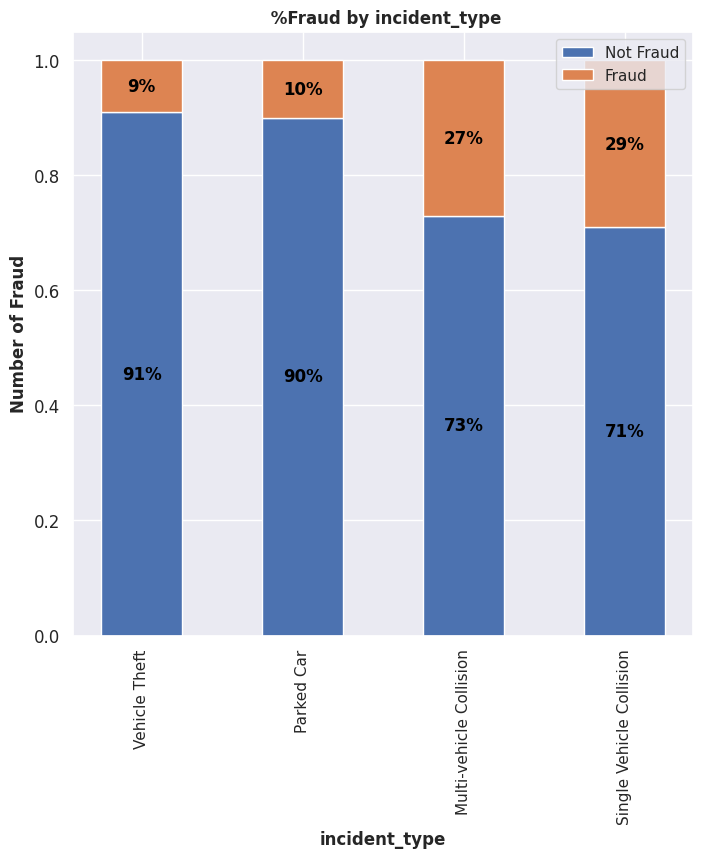

In [ ]:
create_stacked_bar_percent(df,'incident_type')

Perlu di perhatikan tindakan fraud terjadi pada tipe insiden kecelakaan tunggal sebanyak 29% dibandingkan tipe insiden yang lainnya.

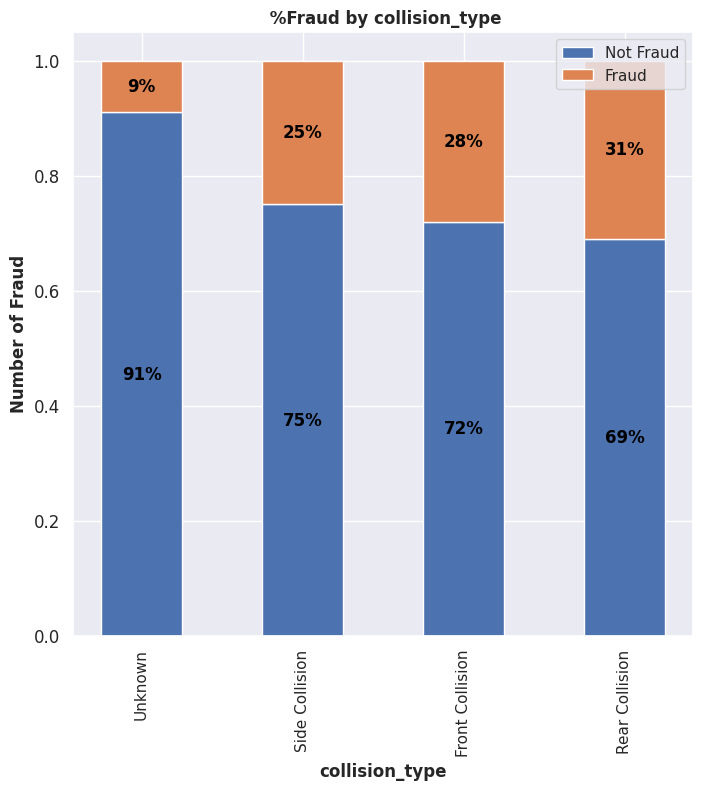

In [ ]:
create_stacked_bar_percent(df,'collision_type')

Perlu di perhatikan tindakan fraud terjadi pada jenis tabrakan dari belakang sebanyak 31% dibandingkan tipe jenis tabrakan yang lainnya.

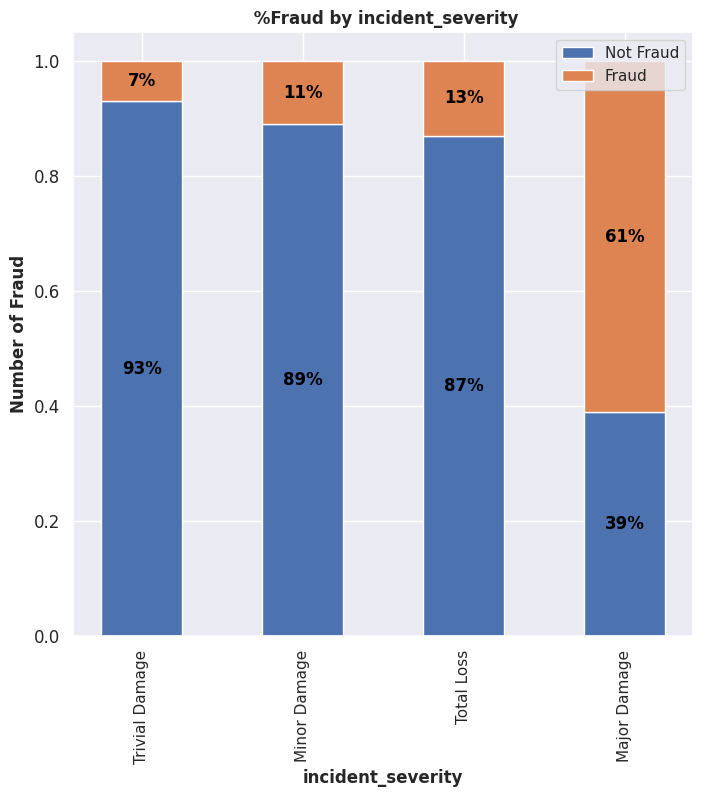

In [ ]:
create_stacked_bar_percent(df,'incident_severity')

Perlu di perhatikan tingkat keparahan kecelakaan yang terjadi kebanyakan mengalami kerusakan besar sebanyak 61%

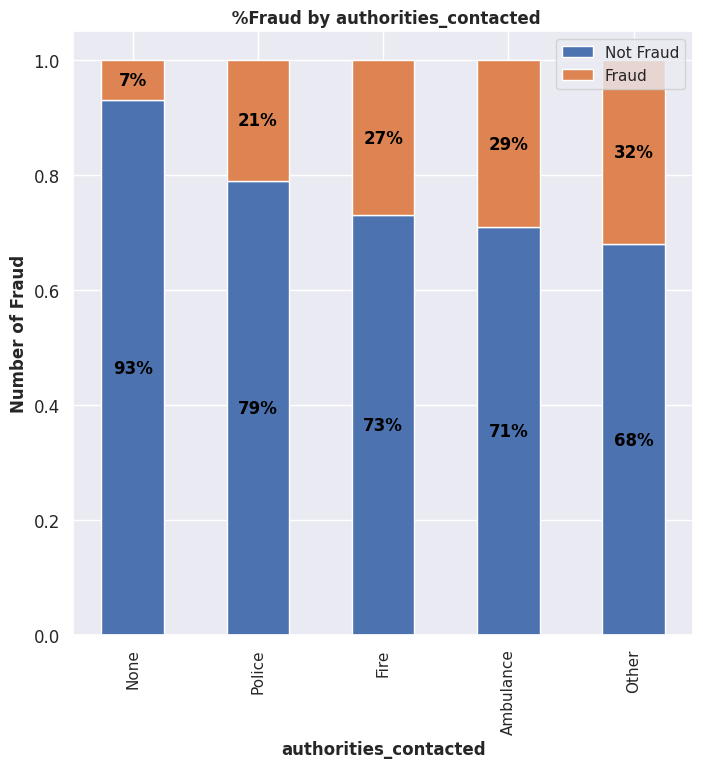

In [ ]:
create_stacked_bar_percent(df,'authorities_contacted')

Sebanyak 32% tindakan fraud terjadi ketika pihak pertama yang dihubungi saat kejadian adalah pihak lain yang dimana itu bertujuan untuk memanipulasi data ataupun berita mengenai kejadian tersebut agar mendapatkan claim asuransi

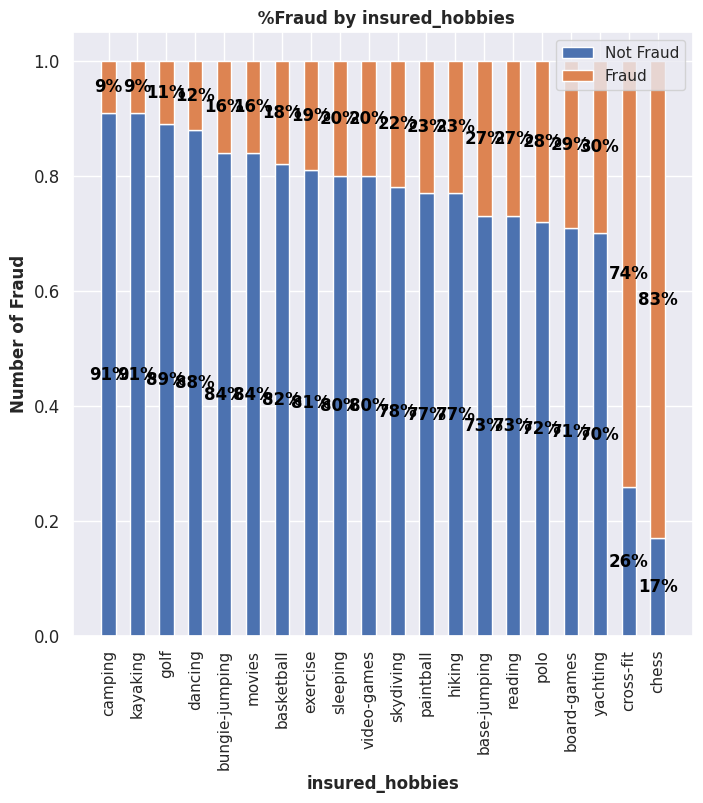

In [ ]:
create_stacked_bar_percent(df,'insured_hobbies')

Sebesar 83% yang melakukan tindakan fraud ialah nasabah yang memiliki hobi chess

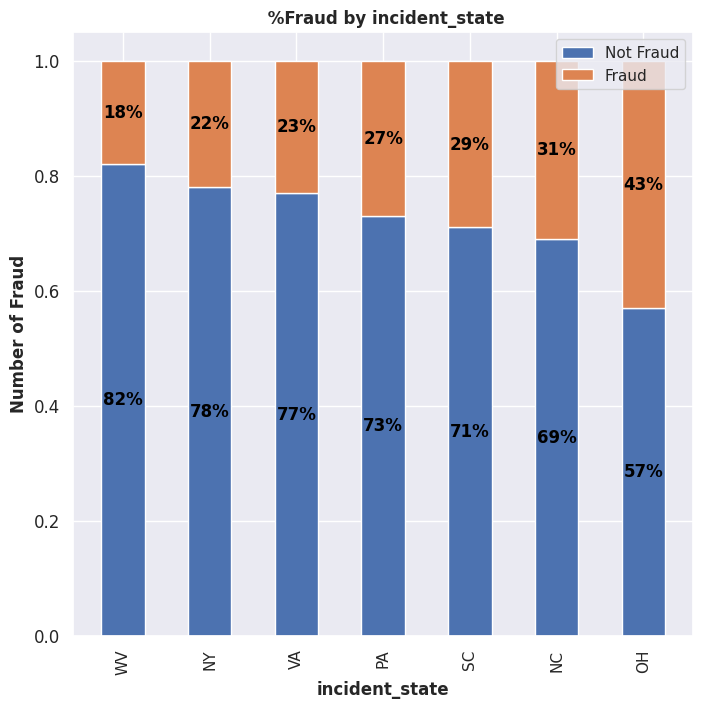

In [ ]:
create_stacked_bar_percent(df,'incident_state')

Sebanyak 43% tindakan fraud terjadi dimana terdapat kecelakaan di lokasi daerah negara OH

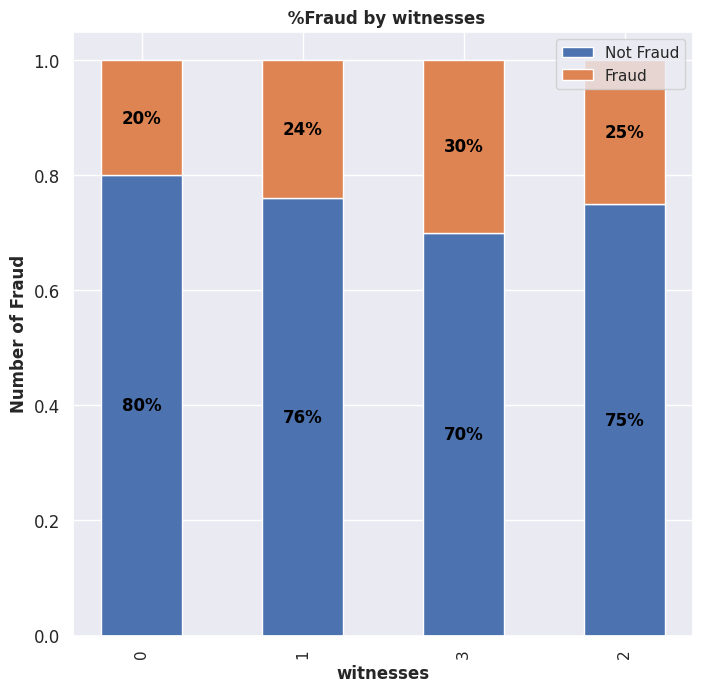

In [ ]:
create_stacked_bar_percent(df,'witnesses')

Sebanyak 30% yang melakukan tindakan fraud akan membawa sebanyak 3 saksi mata dalam tindakannya tersebut dengan tujuan agar pihak asuransi dapat mempercayai dan mempermudah mengurus claim dari kecelakaan tersebut.

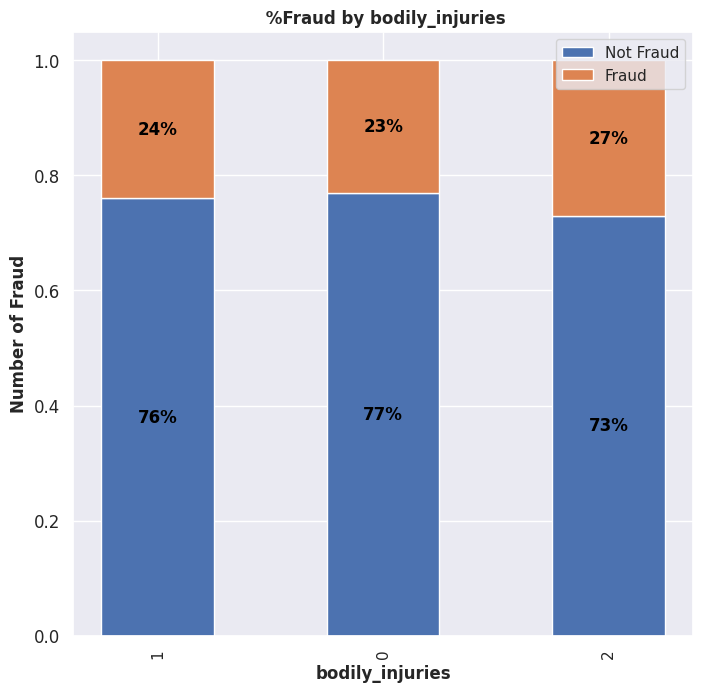

In [ ]:
create_stacked_bar_percent(df,'bodily_injuries')

Sebanyak 27% tindakan fraud akan menyertakan korban luka sebanyak 2 orang demi mempermudah urusan claim atas kejadian tersebut.

Result:


Berdasarkan data tersebut model di atas kasus Fraud terjadi kebanyakan pada nasabah yang memiliki hobi bermain catur. Dimana kecelakaan yang terjadi kebanyakan terletak di negara OH dengan jenis insiden yaitu kecelakaan tunggal dimana menabrakkan kendaraan dari belakang yang mengakibatkan korban luka dan setelah itu melaporkan kepada pihak yang lain dan memberikan saksi mata atas kejadian tersebut.

Maka dari itu pihak asuransi harus memperhatikan data-data yang di terima apakah data tersebut valid atau tidak. beserta pernyataan dari pihak berwenang ataupun cctv kecelakaan dari daerah tempat tersebut. Untuk mengurangi tindakan fraud tersebut

#No 4 Model Machine Learning

In [ ]:
#ordinal category
ord_policy_csl = {'100/300':1,
                 '250/500':2,
                  '500/1000':3}
properti_damage = {"NO":0,
                   "YES":1,
                   "Unknown":2}
incident_type = {"Parked Car":0,
                 "Vehicle Theft":1,
                 "Multi-vehicle Collision":2,
                 "Single Vehicle Collision":3}
incident_severity = {"Trivial Damage":1,
                     "Minor Damage":2,
                     "Total Loss":3,
                     "Major Damage":4}

X_train["policy_csl"] = X_train["policy_csl"].map(ord_policy_csl)
X_train['incident_severity'] = X_train['incident_severity'].map(incident_severity)
X_train["incident_type"] = X_train["incident_type"].map(incident_type)
X_train["property_damage"] = X_train["property_damage"].map(properti_damage)
X_test["policy_csl"] = X_test["policy_csl"].map(ord_policy_csl)
X_test['incident_severity'] = X_test['incident_severity'].map(incident_severity)
X_test["incident_type"] = X_test["incident_type"].map(incident_type)
X_test["property_damage"] = X_test["property_damage"].map(properti_damage)

#nominal cat
cat_nom_col =["insured_occupation","insured_hobbies","authorities_contacted","collision_type","incident_state"]

#for training
dummies = pd.DataFrame()
for x in cat_nom_col:
  dummies = pd.get_dummies(X_train[x],prefix=x+"_")
  X_train = pd.concat([X_train,dummies],axis=1)

#for testing
dummies_1 = pd.DataFrame()
for x in cat_nom_col:
  dummies_1 = pd.get_dummies(X_test[x],prefix=x+"_")
  X_test = pd.concat([X_test,dummies_1],axis=1)

#drop col
X_train = X_train.drop(cat_nom_col,axis=1)
X_test = X_test.drop(cat_nom_col,axis=1)

In [ ]:
X_train.head()

months_as_customer  age policy_bind_date policy_state  \
policy_number                                                          
796005                        173   36        8/18/2007           OH   
184938                          2   28        5/22/1999           IL   
615047                        286   47       11/20/2002           IN   
593466                        435   60       11/21/2006           OH   
454086                        216   36       11/10/1992           IN   

               policy_csl  policy_deductable  policy_annual_premium  \
policy_number                                                         
796005                  2               1000                1274.63   
184938                  2               1000                1340.56   
615047                  2                500                1386.93   
593466                  3                500                1064.49   
454086                  3               1000                1152.40   

               umbrella_limit  insured_zip insured_sex  ...  \
policy_number                                           ...   
796005                      0       441298        MALE  ...   
184938                      0       433184      FEMALE  ...   
615047                      0       457130        MALE  ...   
593466                5000000       462804        MALE  ...   
454086                      0       615921      FEMALE  ...   

              collision_type__Rear Collision collision_type__Side Collision  \
policy_number                                                                 
796005                                     1                              0   
184938                                     0                              1   
615047                                     1                              0   
593466                                     0                              0   
454086                                     0                              0   

               collision_type__Unknown  incident_state__NC incident_state__NY  \
policy_number                                                                   
796005                               0                   0                  0   
184938                               0                   0                  1   
615047                               0                   0                  1   
593466                               0                   0                  0   
454086                               1                   0                  0   

               incident_state__OH  incident_state__PA incident_state__SC  \
policy_number                                                              
796005                          0                   0                  1   
184938                          0                   0                  0   
615047                          0                   0                  0   
593466                          0                   0                  0   
454086                          0                   0                  0   

              incident_state__VA  incident_state__WV  
policy_number                                         
796005                         0                   0  
184938                         0                   0  
615047                         0                   0  
593466                         0                   1  
454086                         1                   0  

[5 rows x 82 columns]



> # Logistic Regression



In [ ]:
#update variable by dropping unused column for modelling later
X_train = X_train.drop(["insured_relationship","insured_education_level","incident_city","insured_sex","police_report_available",
                          "auto_make","incident_date","policy_bind_date","auto_model","incident_location",
                          "insured_zip","months_as_customer","age", "policy_state"],axis=1)
X_test = X_test[X_train.columns.to_list()]

In [ ]:
# Logistic regression
logreg = LogisticRegression()

#params
random_grid = {"penalty":["elasticnet","l2"],
       "fit_intercept":[True,False],
       "C": [0.25, 0.5, 0.75, 1.0]}

scoreFunction = {"f1": "f1"}
random_search = RandomizedSearchCV(logreg,
                                   param_distributions = random_grid,
                                   n_iter = 16,
                                   scoring = scoreFunction,               
                                   refit = "f1", 
                                   return_train_score = False,
                                   random_state = 1000,
                                   verbose = 2,
                                   cv = 3,
                                   n_jobs = -1) 

#trains and optimizes the model
random_search.fit(X_train, y_train)

print('Finished RandomizedSearchCV')

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Finished RandomizedSearchCV


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
24 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver



> # KNN



In [ ]:
# KNN
knn = KNeighborsClassifier()

#params
random_grid = {"n_neighbors": [2,3,4,5],
       "p":[1,2]}

scoreFunction = {"f1": "f1"}
random_search = RandomizedSearchCV(knn,
                                   param_distributions = random_grid,
                                   n_iter = 100,
                                   scoring = scoreFunction,               
                                   refit = "f1", 
                                   return_train_score = False,
                                   random_state = 0,
                                   verbose = 2,
                                   cv = 3,
                                   n_jobs = -1) 

#trains and optimizes the model
random_search.fit(X_train, y_train)

print('Finished RandomizedSearchCV')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Finished RandomizedSearchCV


              precision    recall  f1-score   support

           0       0.86      0.93      0.89       527
           1       0.71      0.53      0.60       173

    accuracy                           0.83       700
   macro avg       0.78      0.73      0.75       700
weighted avg       0.82      0.83      0.82       700



Text(120.5, 0.5, 'Real')

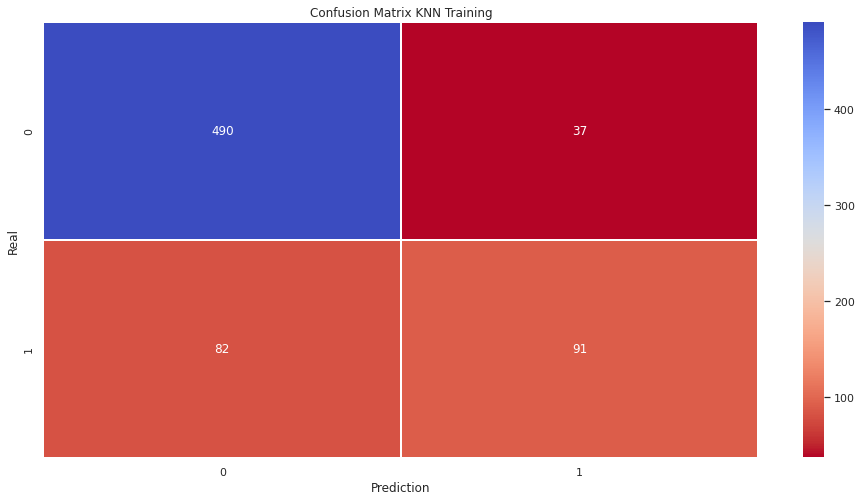

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_train, random_search.predict(X_train))
print(metrics.classification_report(y_train,random_search.predict(X_train)))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix KNN Training')
plt.xlabel('Prediction')
plt.ylabel('Real')

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train,random_search.predict_proba(X_train)[:,1])
roc_auc_value = roc_auc_score(y_train, random_search.predict_proba(X_train)[:,1]).round(4)
gini_value = ((2*roc_auc_value)-1).round(4)

print('AUC for KNN on val data: ', round(roc_auc_value*100, 2), '%')
print('Gini for KNN Forest on val data: ', round(gini_value*100, 2), '%')

AUC for KNN on val data:  87.72 %
Gini for KNN Forest on val data:  75.44 %


              precision    recall  f1-score   support

           0       0.77      0.89      0.83       226
           1       0.35      0.18      0.23        74

    accuracy                           0.72       300
   macro avg       0.56      0.53      0.53       300
weighted avg       0.67      0.72      0.68       300



Text(120.5, 0.5, 'Real')

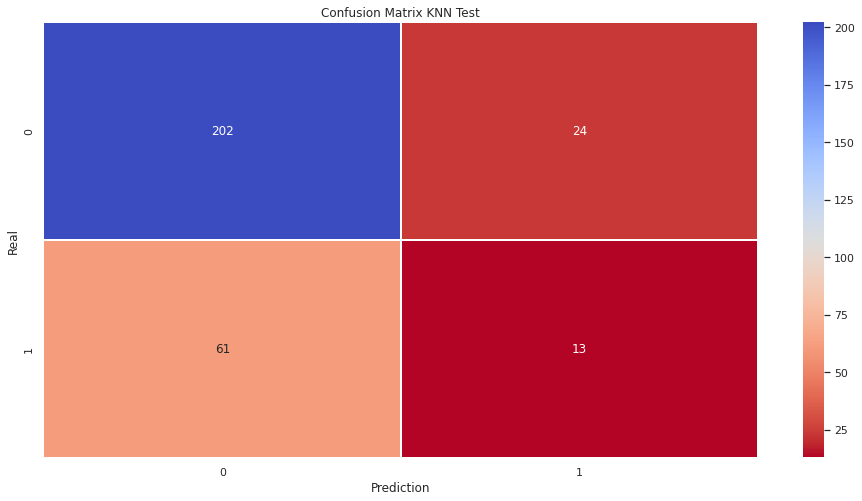

In [ ]:
# predict test
cnf_matrix = metrics.confusion_matrix(y_test, random_search.predict(X_test))
print(metrics.classification_report(y_test,random_search.predict(X_test)))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix KNN Test')
plt.xlabel('Prediction')
plt.ylabel('Real')

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test,random_search.predict_proba(X_test)[:,1])
roc_auc_value = roc_auc_score(y_test, random_search.predict_proba(X_test)[:,1]).round(4)
gini_value = ((2*roc_auc_value)-1).round(4)

print('AUC for Logreg  on val data: ', round(roc_auc_value*100, 2), '%')
print('Gini for Logreg  on val data: ', round(gini_value*100, 2), '%')

AUC for Logreg  on val data:  56.4 %
Gini for Logreg  on val data:  12.8 %




> # Random Forest



In [ ]:
# Random Forest
rf = RandomForestClassifier()

random_grid = {'n_estimators': [10, 50, 100, 1000],
               'max_features': ["sqrt", "log2"],
               'max_depth': [3,5,10, None],
               'criterion':['gini','entropy']}

scoreFunction = {"f1": "f1"}

random_search = RandomizedSearchCV(rf,
                                   param_distributions = random_grid,
                                   n_iter = 100,
                                   scoring = scoreFunction,               
                                   refit = "f1", 
                                   return_train_score = False,
                                   random_state = 0,
                                   verbose = 2,
                                   cv = 3,
                                   n_jobs = -1) 

#trains and optimizes the model
random_search.fit(X_train, y_train)

print('Finished RandomizedSearchCV ')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 64 is smaller than n_iter=100. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 3 folds for each of 64 candidates, totalling 192 fits
Finished RandomizedSearchCV 


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       527
           1       1.00      1.00      1.00       173

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700



Text(120.5, 0.5, 'Real')

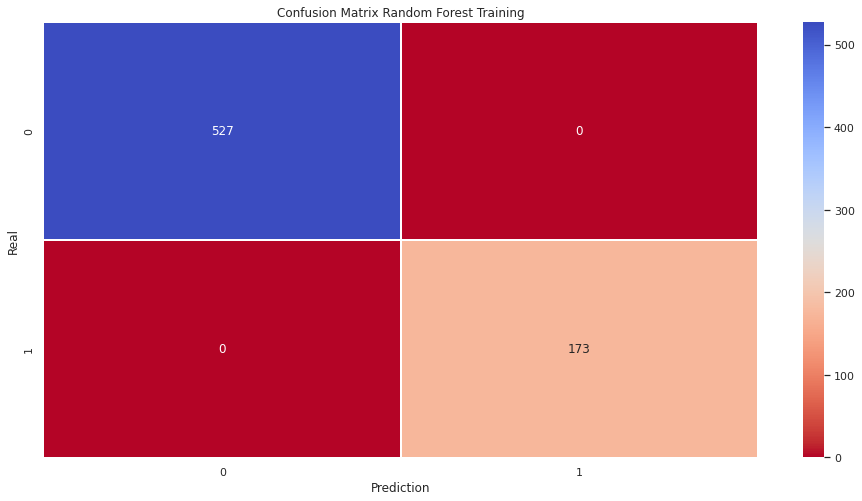

In [ ]:
#pedict train
cnf_matrix = metrics.confusion_matrix(y_train, random_search.predict(X_train))
print(metrics.classification_report(y_train,random_search.predict(X_train)))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix Random Forest Training')
plt.xlabel('Prediction')
plt.ylabel('Real')

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train,random_search.predict_proba(X_train)[:,1])
roc_auc_value = roc_auc_score(y_train, random_search.predict_proba(X_train)[:,1]).round(4)
gini_value = ((2*roc_auc_value)-1).round(4)

print('AUC for Logreg on val data: ', round(roc_auc_value*100, 2), '%')
print('Gini for Logreg Forest on val data: ', round(gini_value*100, 2), '%')

AUC for Logreg on val data:  100.0 %
Gini for Logreg Forest on val data:  100.0 %


              precision    recall  f1-score   support

           0       0.87      0.89      0.88       226
           1       0.64      0.59      0.62        74

    accuracy                           0.82       300
   macro avg       0.75      0.74      0.75       300
weighted avg       0.81      0.82      0.81       300



Text(120.5, 0.5, 'Real')

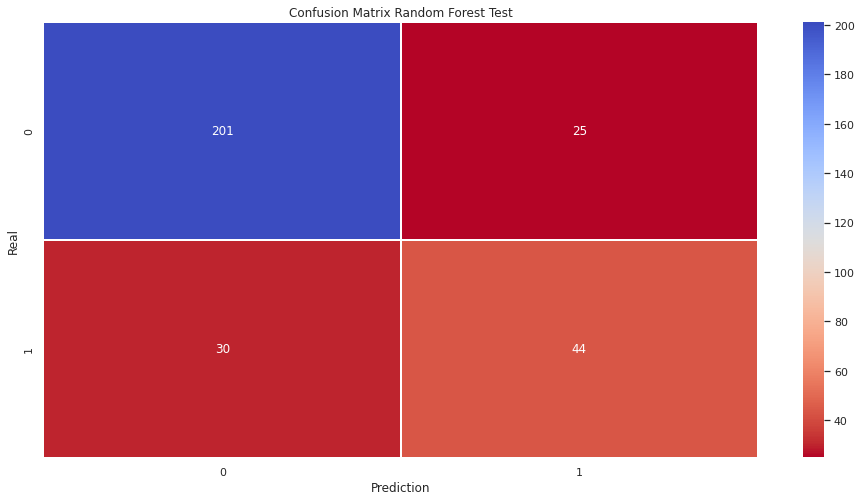

In [ ]:
# predict test
cnf_matrix = metrics.confusion_matrix(y_test, random_search.predict(X_test))
print(metrics.classification_report(y_test,random_search.predict(X_test)))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix Random Forest Test')
plt.xlabel('Prediction')
plt.ylabel('Real')


In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test,random_search.predict_proba(X_test)[:,1])
roc_auc_value = roc_auc_score(y_test, random_search.predict_proba(X_test)[:,1]).round(4)
gini_value = ((2*roc_auc_value)-1).round(4)

print('AUC for Logreg  on val data: ', round(roc_auc_value*100, 2), '%')
print('Gini for Logreg  on val data: ', round(gini_value*100, 2), '%')

AUC for Logreg  on val data:  83.55 %
Gini for Logreg  on val data:  67.1 %




> # XG Boost



In [ ]:
# XGBoost
xgb = XGBClassifier()

random_grid = {'n_estimators': [10, 50, 100],
               "learning_rate": [0.1, 0.05, 0.01],
               'max_depth': [3,5,10],
               "grow_policy": ["depthwise", "lossguide"]}

scoreFunction = {"f1": "f1"}

random_search = RandomizedSearchCV(xgb,
                                   param_distributions = random_grid,
                                   n_iter = 100,
                                   scoring = scoreFunction,               
                                   refit = "f1", 
                                   return_train_score = False,
                                   random_state = 0,
                                   verbose = 2,
                                   cv = 3,
                                   n_jobs = -1) 

#trains and optimizes the model
random_search.fit(X_train, y_train)

print('Finished RandomizedSearchCV ')

Fitting 3 folds for each of 54 candidates, totalling 162 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 54 is smaller than n_iter=100. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Finished RandomizedSearchCV 


              precision    recall  f1-score   support

           0       0.96      0.90      0.93       527
           1       0.74      0.88      0.81       173

    accuracy                           0.89       700
   macro avg       0.85      0.89      0.87       700
weighted avg       0.90      0.89      0.90       700



Text(120.5, 0.5, 'Realita')

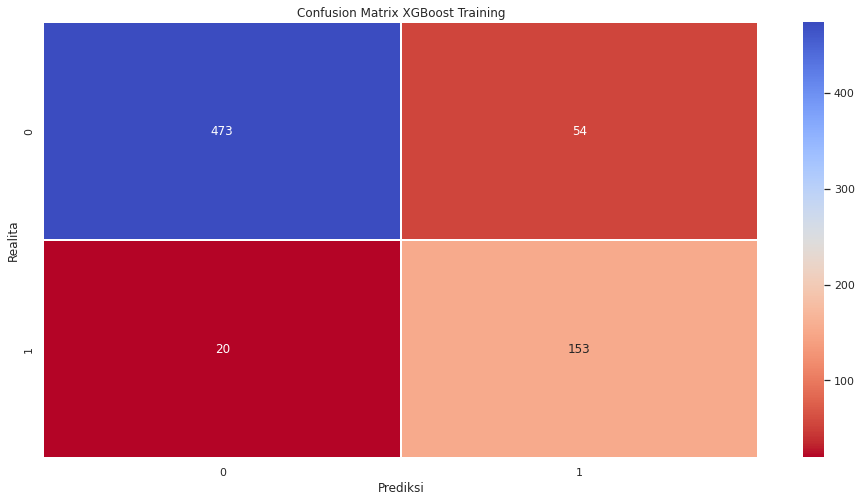

In [ ]:
# predict training
cnf_matrix = metrics.confusion_matrix(y_train, random_search.best_estimator_.predict(X_train))
print(metrics.classification_report(y_train,random_search.best_estimator_.predict(X_train)))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix XGBoost Training')
plt.xlabel('Prediksi')
plt.ylabel('Realita')

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train,random_search.best_estimator_.predict_proba(X_train)[:,1])
roc_auc_value = roc_auc_score(y_train, random_search.best_estimator_.predict_proba(X_train)[:,1]).round(4)
gini_value = ((2*roc_auc_value)-1).round(4)

print('AUC for XGBOOST on val data: ', round(roc_auc_value*100, 2), '%')
print('Gini for XGBOOST Forest on val data: ', round(gini_value*100, 2), '%')

AUC for XGBOOST on val data:  91.62 %
Gini for XGBOOST Forest on val data:  83.24 %


              precision    recall  f1-score   support

           0       0.91      0.84      0.87       226
           1       0.60      0.74      0.67        74

    accuracy                           0.82       300
   macro avg       0.76      0.79      0.77       300
weighted avg       0.83      0.82      0.82       300



Text(120.5, 0.5, 'Realita')

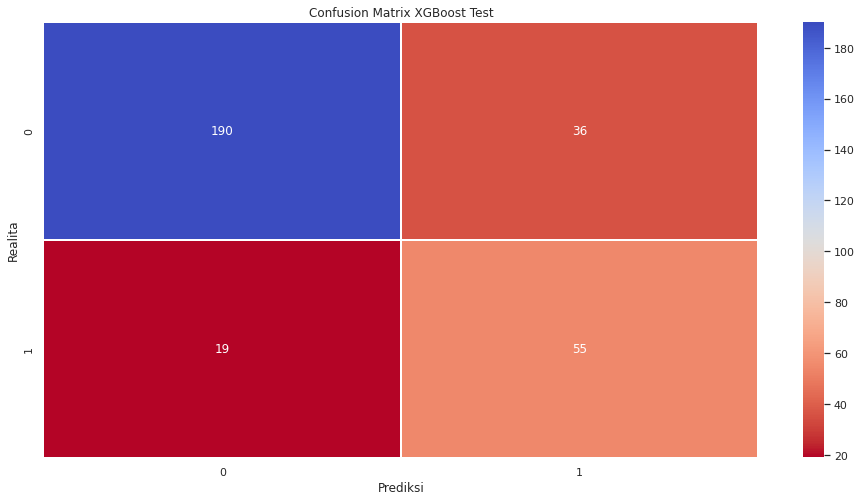

In [ ]:
# predict test
cnf_matrix = metrics.confusion_matrix(y_test, random_search.best_estimator_.predict(X_test))
print(metrics.classification_report(y_test,random_search.best_estimator_.predict(X_test)))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix XGBoost Test')
plt.xlabel('Prediksi')
plt.ylabel('Realita')

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test,random_search.best_estimator_.predict_proba(X_test)[:,1])
roc_auc_value = roc_auc_score(y_test, random_search.best_estimator_.predict_proba(X_test)[:,1]).round(4)
gini_value = ((2*roc_auc_value)-1).round(4)

print('AUC for XGBOOST  on val data: ', round(roc_auc_value*100, 2), '%')
print('Gini for XGBOOST  on val data: ', round(gini_value*100, 2), '%')

AUC for XGBOOST  on val data:  84.32 %
Gini for XGBOOST  on val data:  68.64 %


# No 5 Interpretasi Model

In [ ]:
#Feature Importance
feature_importance = pd.DataFrame({
    'Features':X_train.columns,
    'Importance':random_search.best_estimator_.feature_importances_}).sort_values('Importance', ascending=False)

In [ ]:
feature_importance[feature_importance["Importance"]>0]["Features"].values

array(['incident_severity', 'insured_hobbies__chess',
       'insured_hobbies__cross-fit', 'auto_year', 'policy_annual_premium',
       'incident_type', 'capital-loss',
       'authorities_contacted__Ambulance', 'injury_claim',
       'collision_type__Side Collision', 'total_claim_amount',
       'bodily_injuries', 'incident_state__PA', 'property_claim'],
      dtype=object)

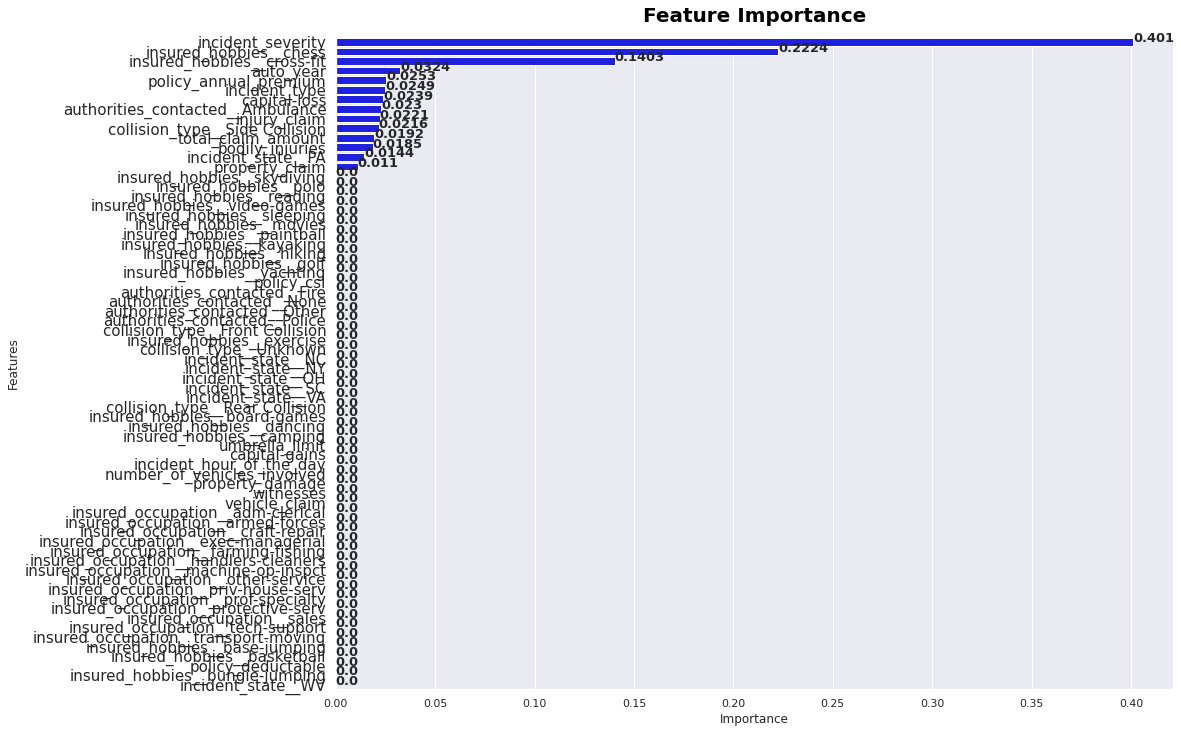

In [ ]:
plt.figure(figsize=(15, 12))
sns.barplot(data=feature_importance, x='Importance', y='Features', color='blue')

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i],i, round(x[i], 4), fontsize=13, fontweight='bold')

x = list(feature_importance['Importance'])
y = list(feature_importance['Features'])

plt.title('Feature Importance', fontsize=20, color='black', pad=15, fontweight='bold')
plt.yticks(fontsize=15)
addlabels(x, y)
plt.show()

In [ ]:
X_train_new = X_train[['incident_severity', 'insured_hobbies__chess',\
       'insured_hobbies__cross-fit',\
       'insured_occupation__priv-house-serv',\
       'authorities_contacted__Ambulance', 'vehicle_claim',\
       'bodily_injuries', 'capital-gains', 'policy_annual_premium',\
       'injury_claim', 'insured_hobbies__exercise',\
       'insured_hobbies__sleeping', 'policy_csl', 'incident_state__SC',\
       'property_claim']]

X_test_new = X_test[['incident_severity', 'insured_hobbies__chess',\
       'insured_hobbies__cross-fit',\
       'insured_occupation__priv-house-serv',\
       'authorities_contacted__Ambulance', 'vehicle_claim',\
       'bodily_injuries', 'capital-gains', 'policy_annual_premium',\
       'injury_claim', 'insured_hobbies__exercise',\
       'insured_hobbies__sleeping', 'policy_csl', 'incident_state__SC',\
       'property_claim']]

In [ ]:
#=====XGBoost New Feature======
xgb = XGBClassifier(random_state=42)


random_grid = {'n_estimators': [10, 50, 100],
               "learning_rate": [0.1, 0.05, 0.01],
               'max_depth': [3,5,10],
               "grow_policy": ["depthwise", "lossguide"]}

scoreFunction = {"f1": "f1"}

random_search_new = RandomizedSearchCV(xgb,
                                   param_distributions = random_grid,
                                   n_iter = 100,
                                   scoring = scoreFunction,               
                                   refit = "f1", 
                                   return_train_score = False,
                                   random_state = 42,
                                   verbose = True,
                                   cv = 3,
                                   n_jobs = -1) 

#trains and optimizes the model
random_search_new.fit(X_train_new, y_train)

print('Finished RandomizedSearchCV ')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 54 is smaller than n_iter=100. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Finished RandomizedSearchCV 


              precision    recall  f1-score   support

           0       0.95      0.90      0.93       527
           1       0.74      0.86      0.80       173

    accuracy                           0.89       700
   macro avg       0.85      0.88      0.86       700
weighted avg       0.90      0.89      0.89       700



Text(120.5, 0.5, 'Realita')

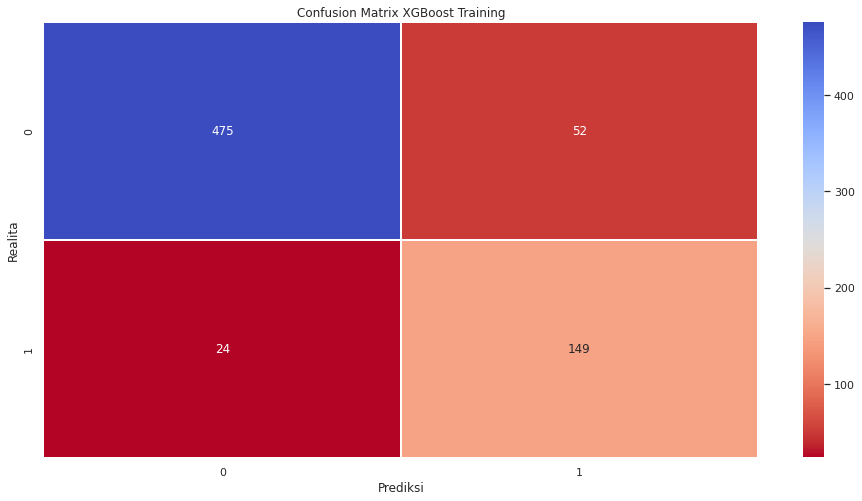

In [ ]:
# predict training
cnf_matrix = metrics.confusion_matrix(y_train, random_search_new.best_estimator_.predict(X_train_new))
print(metrics.classification_report(y_train,random_search_new.best_estimator_.predict(X_train_new)))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix XGBoost Training')
plt.xlabel('Prediksi')
plt.ylabel('Realita')

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train,random_search_new.best_estimator_.predict_proba(X_train_new)[:,1])
roc_auc_value = roc_auc_score(y_train, random_search_new.best_estimator_.predict_proba(X_train_new)[:,1]).round(4)
gini_value = ((2*roc_auc_value)-1).round(4)

print('AUC for XGBOOST on val data: ', round(roc_auc_value*100, 2), '%')
print('Gini for XGBOOST Forest on val data: ', round(gini_value*100, 2), '%')

AUC for XGBOOST on val data:  91.19 %
Gini for XGBOOST Forest on val data:  82.38 %


              precision    recall  f1-score   support

           0       0.91      0.85      0.88       226
           1       0.61      0.73      0.67        74

    accuracy                           0.82       300
   macro avg       0.76      0.79      0.77       300
weighted avg       0.83      0.82      0.82       300



Text(120.5, 0.5, 'Realita')

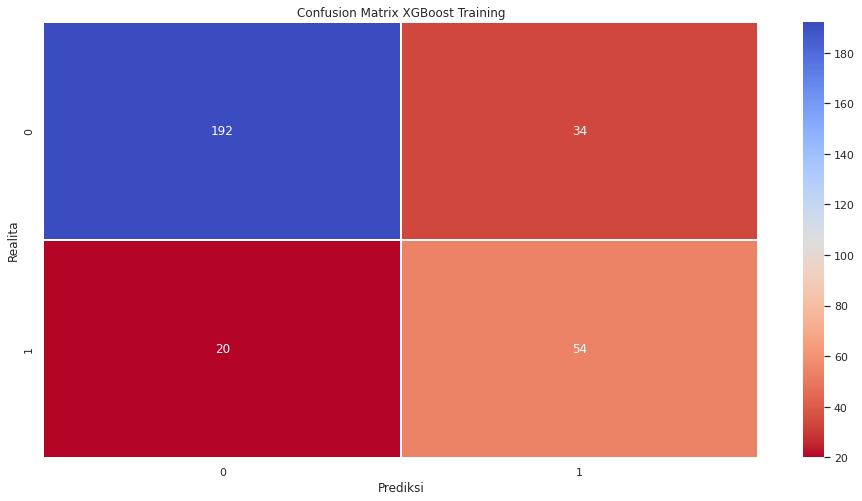

In [ ]:
# predict training
cnf_matrix = metrics.confusion_matrix(y_test, random_search_new.best_estimator_.predict(X_test_new))
print(metrics.classification_report(y_test,random_search_new.best_estimator_.predict(X_test_new)))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix XGBoost Training')
plt.xlabel('Prediksi')
plt.ylabel('Realita')

In [ ]:
# #intrepetasi pdp
!pip install dalex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.3 MB/s 
  Created wheel for dalex: filename=dalex-1.4.1-py3-none-any.whl size=1042860 sha256=61856d57fe9b49cb1999643107c7c52308dcf2bd0ca1430aeff28b9cb45d14a5
  Stored in directory: /root/.cache/pip/wheels/8c/8e/1b/95d59374d386e8e495aed6cbab4c4b6d72be73993a424c5e12
Successfully built dalex


In [ ]:
import dalex as dx
## initiate explainer for Random Forest model
fraud_xgb_exp = dx.Explainer(random_search_new.best_estimator_, X_train_new, y_train, label = "XGBOOST Interpretation")

Preparation of a new explainer is initiated

  -> data              : 700 rows 15 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 700 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGBOOST Interpretation
  -> predict function  : <function yhat_proba_default at 0x7ff119cb73b0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.206, mean = 0.336, max = 0.786
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.695, mean = -0.0887, max = 0.794
  -> model_info        : package xgboost

A new explainer has been created!


In [ ]:
fraud_xgb_exp.model_profile().plot()

Calculating ceteris paribus: 100%|██████████| 15/15 [00:00<00:00, 29.23it/s]


Dari hasil model di atas dapat simpulkan bahwa,

1.Bedasarkan incident severity memiliki probilitas untuk fraud meningkat signifikant menjadi 0.65.

2.untuk insured hobbies chess, ketika seorang pelapor memiliki hobby chess probability untuk fraud sebesar 0.7

3.untuk insured hobbies corss-fit, ketika seorang pelapor memiliki hobby chess probability untuk fraud sebesar 0.62

Jadi berdasarkan hal tersebut tindakan fraud ini perlu di perhatikan dan ditangani dengan baik untuk mengurangi akan probabilitas kenaikan yang significant dengan cara bisa di lihat dari jenis kecelakaan ataupun insiden yang terjadi serta bukti pengajuan claim yang terlegalisir oleh pihak tertentu.

# No 6 LIME Models



> # Indeksing



In [ ]:
x = X_test.reset_index()
s = X_train.reset_index()
x.head()

policy_number  policy_csl  policy_deductable  policy_annual_premium  \
0         501692           1               1000                1134.68   
1         261905           3                500                1312.22   
2         200152           1               1000                 988.45   
3         540152           1                500                1256.20   
4         792673           3               2000                1233.96   

   umbrella_limit  capital-gains  capital-loss  incident_type  \
0               0              0             0              3   
1         9000000              0        -33300              2   
2               0              0             0              3   
3               0              0             0              2   
4               0          34500        -60600              2   

   incident_severity  incident_hour_of_the_day  ...  \
0                  4                        18  ...   
1                  2                        15  ...   
2                  3                         3  ...   
3                  2                        10  ...   
4                  3                        16  ...   

   collision_type__Rear Collision  collision_type__Side Collision  \
0                               1                               0   
1                               0                               0   
2                               1                               0   
3                               0                               1   
4                               0                               1   

   collision_type__Unknown  incident_state__NC  incident_state__NY  \
0                        0                   0                   0   
1                        0                   1                   0   
2                        0                   0                   1   
3                        0                   0                   0   
4                        0                   1                   0   

   incident_state__OH  incident_state__PA  incident_state__SC  \
0                   0                   0                   1   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   1   
4                   0                   0                   0   

   incident_state__VA  incident_state__WV  
0                   0                   0  
1                   0                   0  
2                   0                   0  
3                   0                   0  
4                   0                   0  

[5 rows x 69 columns]

In [ ]:
x[x["policy_number"]==527945]

policy_number  policy_csl  policy_deductable  policy_annual_premium  \
253         527945           2                500                1307.11   

     umbrella_limit  capital-gains  capital-loss  incident_type  \
253               0              0             0              2   

     incident_severity  incident_hour_of_the_day  ...  \
253                  3                        22  ...   

     collision_type__Rear Collision  collision_type__Side Collision  \
253                               0                               0   

     collision_type__Unknown  incident_state__NC  incident_state__NY  \
253                        0                   0                   0   

     incident_state__OH  incident_state__PA  incident_state__SC  \
253                   0                   0                   0   

     incident_state__VA  incident_state__WV  
253                   0                   1  

[1 rows x 69 columns]

In [ ]:
s[s["policy_number"]==235220]

policy_number  policy_csl  policy_deductable  policy_annual_premium  \
596         235220           2               2000                1352.83   

     umbrella_limit  capital-gains  capital-loss  incident_type  \
596               0              0        -71700              2   

     incident_severity  incident_hour_of_the_day  ...  \
596                  2                         4  ...   

     collision_type__Rear Collision  collision_type__Side Collision  \
596                               1                               0   

     collision_type__Unknown  incident_state__NC  incident_state__NY  \
596                        0                   0                   0   

     incident_state__OH  incident_state__PA  incident_state__SC  \
596                   0                   0                   1   

     incident_state__VA  incident_state__WV  
596                   0                   0  

[1 rows x 69 columns]

In [ ]:
s[s["policy_number"]==605100]

policy_number  policy_csl  policy_deductable  policy_annual_premium  \
505         605100           1                500                1042.25   

     umbrella_limit  capital-gains  capital-loss  incident_type  \
505               0              0        -44400              2   

     incident_severity  incident_hour_of_the_day  ...  \
505                  4                         0  ...   

     collision_type__Rear Collision  collision_type__Side Collision  \
505                               1                               0   

     collision_type__Unknown  incident_state__NC  incident_state__NY  \
505                        0                   1                   0   

     incident_state__OH  incident_state__PA  incident_state__SC  \
505                   0                   0                   0   

     incident_state__VA  incident_state__WV  
505                   0                   0  

[1 rows x 69 columns]



> # Interpreting



In [ ]:
!pip install lime
!pip install -U XGBoost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 4.5 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=14817dd976b742556651c136f4a6c2a25078fdcec0ff4f480349de84375182f8
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from lime.lime_tabular import LimeTabularExplainer 

In [ ]:
X_train_new.iloc[253]

incident_severity                          2.00
insured_hobbies__chess                     0.00
insured_hobbies__cross-fit                 0.00
insured_occupation__priv-house-serv        0.00
authorities_contacted__Ambulance           0.00
vehicle_claim                          69930.00
bodily_injuries                            2.00
capital-gains                              0.00
policy_annual_premium                   1275.81
injury_claim                           15540.00
insured_hobbies__exercise                  0.00
insured_hobbies__sleeping                  0.00
policy_csl                                 3.00
incident_state__SC                         0.00
property_claim                         15540.00
Name: 806081, dtype: float64

In [ ]:
explainer = LimeTabularExplainer(training_data=np.array(X_train_new),
        feature_names= X_train_new.columns,
        class_names=["no_fraud","fraud"],
        mode='classification',
        verbose=True,
        random_state=42)

In [ ]:
expXGB = explainer.explain_instance(data_row = X_train_new.iloc[253],
                                    predict_fn = random_search_new.best_estimator_.predict_proba,
                                    num_features=15)
expXGB.show_in_notebook(show_table=True)

Intercept 1.0830779382975346
Prediction_local [0.23074525]
Right: 0.2060546


Dari hasil model tersebut plat 527945 tidak ada indikasi melakukan fraud karena probabilitas melakukan fraud sangat kecil hanya 0.21 semantara untuk tidak melakukannya sebesar 0.79

In [ ]:
X_train_new.iloc[596]

incident_severity                          2.00
insured_hobbies__chess                     0.00
insured_hobbies__cross-fit                 0.00
insured_occupation__priv-house-serv        0.00
authorities_contacted__Ambulance           0.00
vehicle_claim                          50470.00
bodily_injuries                            1.00
capital-gains                              0.00
policy_annual_premium                   1352.83
injury_claim                            7210.00
insured_hobbies__exercise                  0.00
insured_hobbies__sleeping                  0.00
policy_csl                                 2.00
incident_state__SC                         1.00
property_claim                          7210.00
Name: 235220, dtype: float64

In [ ]:
expXGB = explainer.explain_instance(data_row = X_train_new.iloc[596],
                                    predict_fn = random_search_new.best_estimator_.predict_proba,
                                    num_features=15)
expXGB.show_in_notebook(show_table=True)

Intercept 1.0781816356152016
Prediction_local [0.21802119]
Right: 0.2060546


Dari hasil model tersebut plat 235220 tidak ada indikasi melakukan fraud karena probabilitas melakukan fraud sangat kecil hanya 0.21 sementara untuk tidak melakukannya sebesar 0.79



In [ ]:
X_train_new.iloc[505]

incident_severity                          4.00
insured_hobbies__chess                     0.00
insured_hobbies__cross-fit                 0.00
insured_occupation__priv-house-serv        0.00
authorities_contacted__Ambulance           0.00
vehicle_claim                          54160.00
bodily_injuries                            2.00
capital-gains                              0.00
policy_annual_premium                   1042.25
injury_claim                            6770.00
insured_hobbies__exercise                  0.00
insured_hobbies__sleeping                  0.00
policy_csl                                 1.00
incident_state__SC                         0.00
property_claim                         20310.00
Name: 605100, dtype: float64

In [ ]:
expXGB = explainer.explain_instance(data_row = X_train_new.iloc[505],
                                    predict_fn = random_search_new.best_estimator_.predict_proba,
                                    num_features=15)
expXGB.show_in_notebook(show_table=True)

Intercept 0.8772472463227906
Prediction_local [0.55264464]
Right: 0.6037805


Dari hasil model tersebut plat 605100 ada indikasi melakukan fraud dengan probabilitas melakukannya sebesar 0.60